In [5]:
#Linear regression
from sklearn.linear_model import LinearRegression

#Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import csv
import pandas as pd
from collections import defaultdict
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
plt.rcParams['figure.dpi'] = 360

In [4]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

### Create graph

In [1]:
def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.append(float(values[1]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [6]:
nodes, edges, distances = graph_r(rosettes[0])

### Correlation matrix

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_93889/1155875418.py:8: RuntimeWarning: divide by zero encountered in log10
  ed = [np.log10(c[n[0]]) for n in nodes]


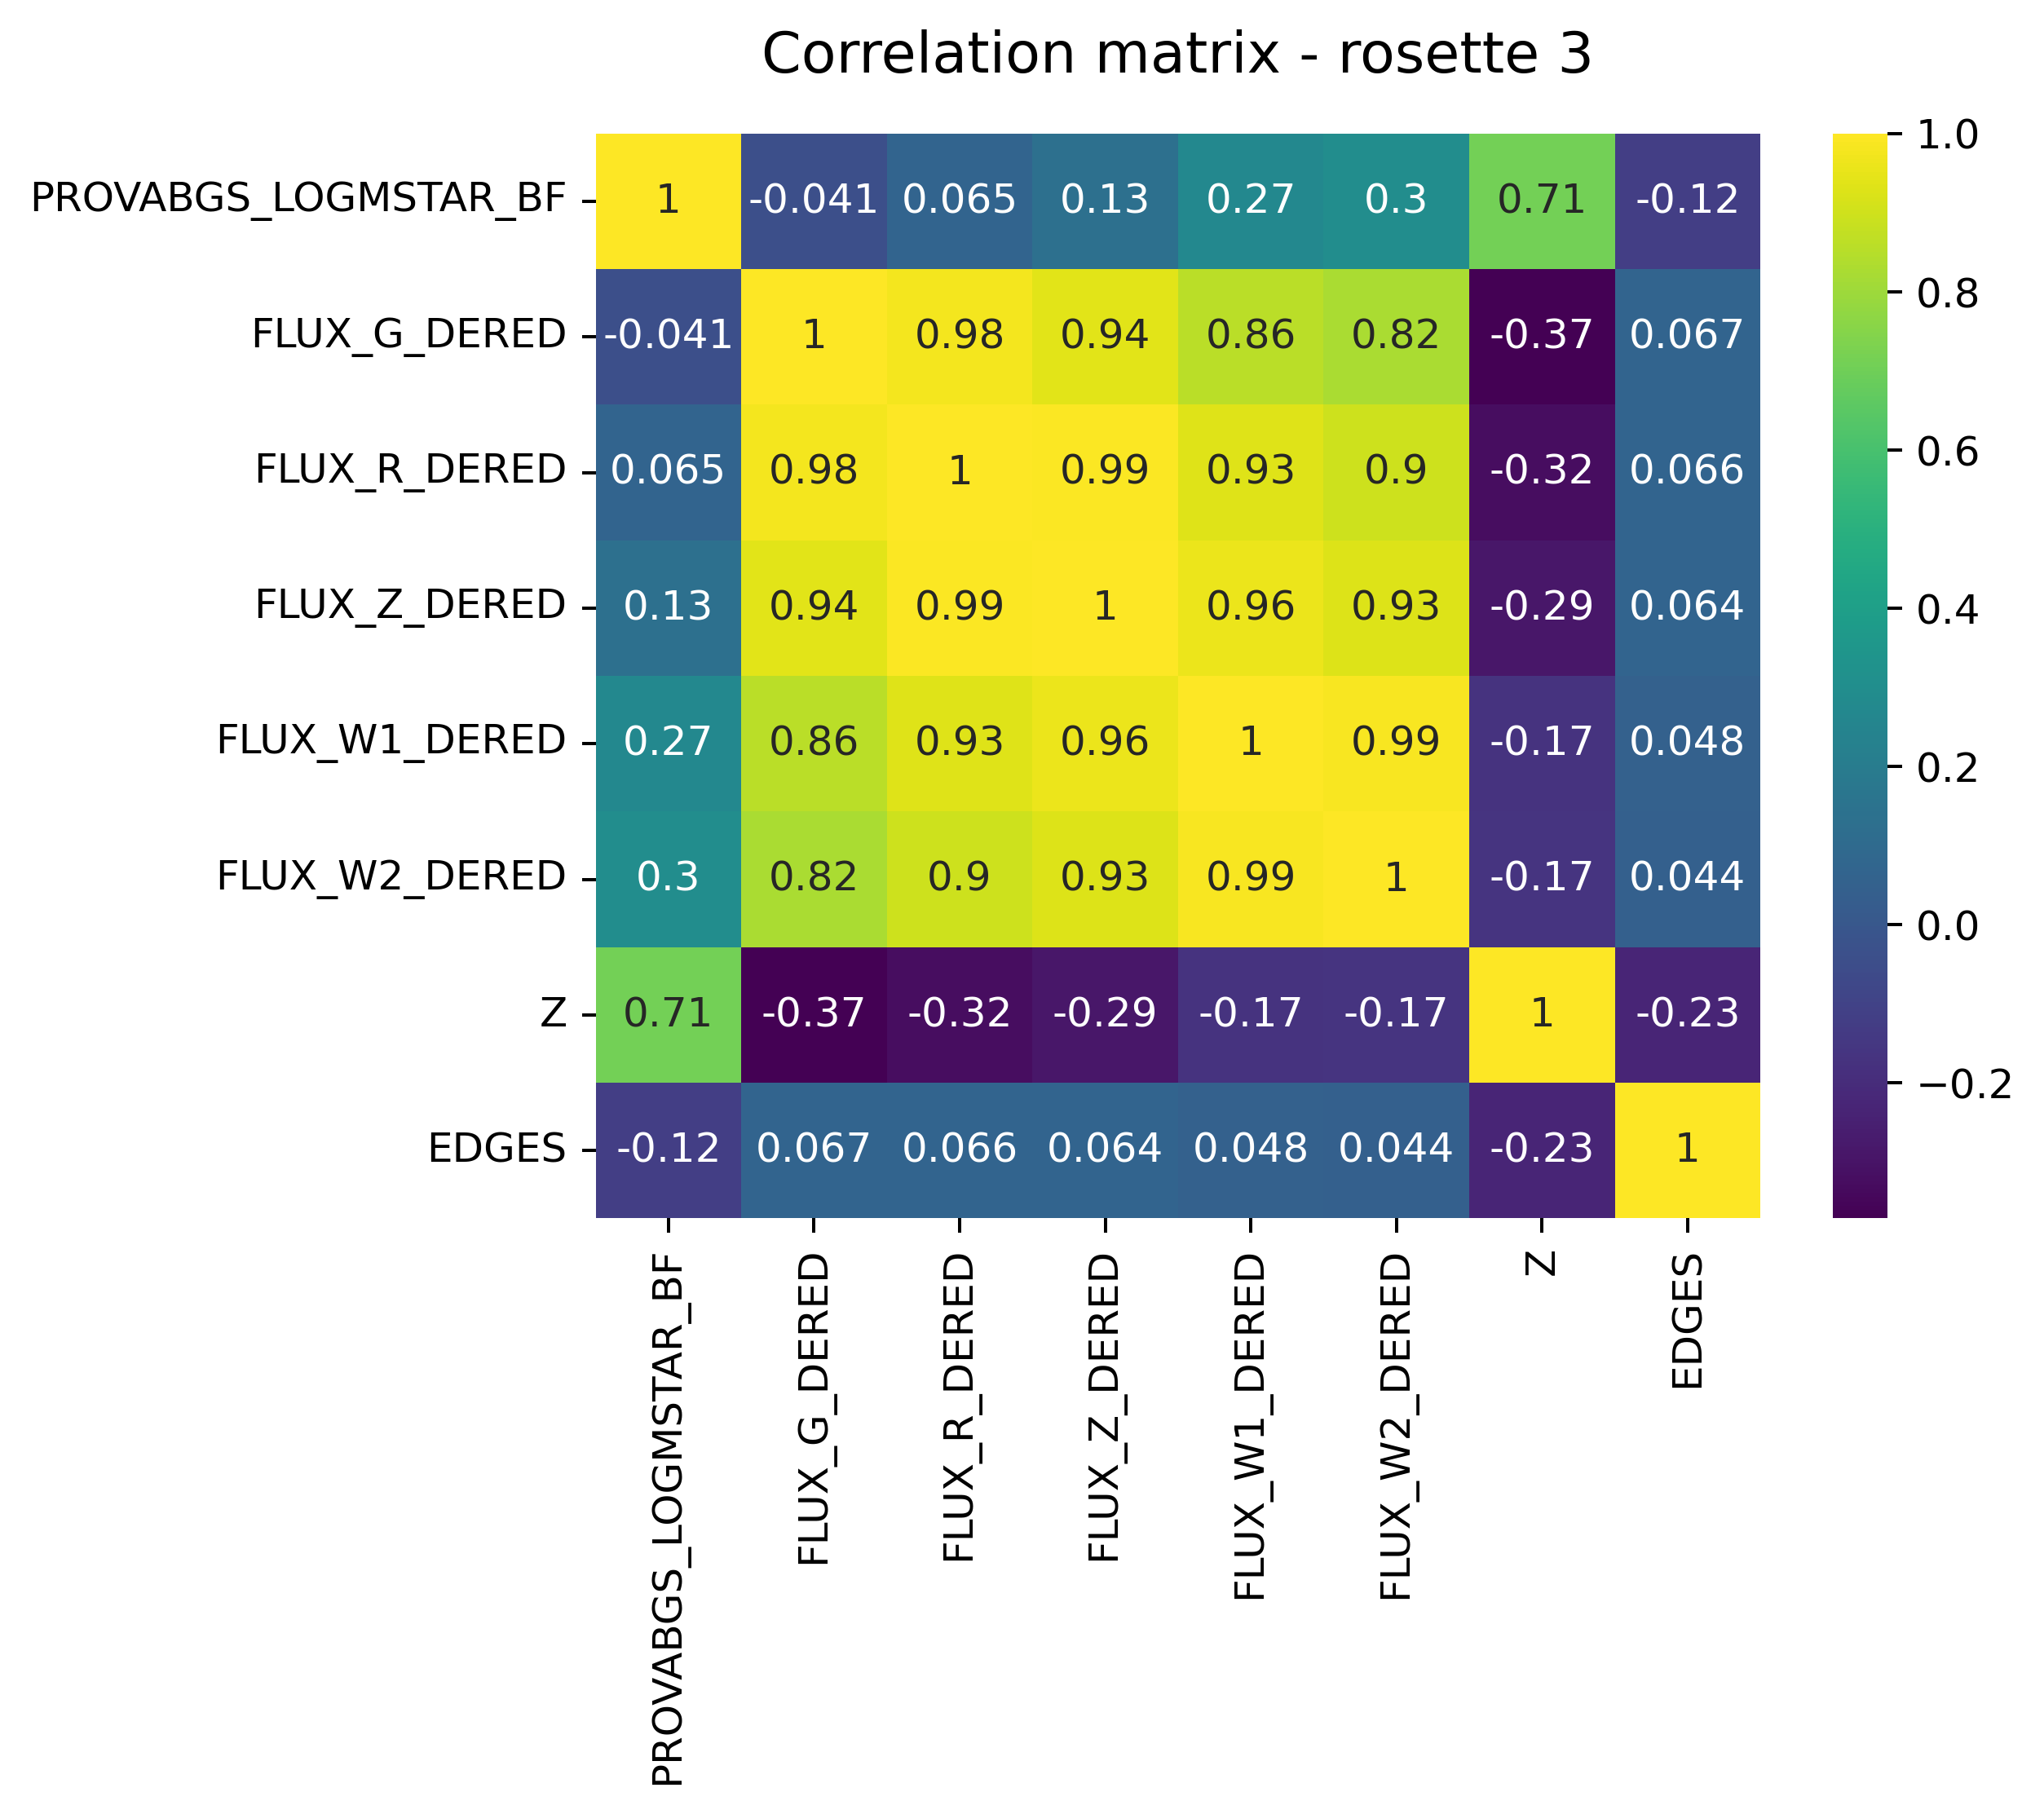

In [7]:
def correlation_matrix(r,nodes,edges):

    df = pd.read_csv(f'./data/rosette{r}_nodes.csv')
    c = defaultdict(int)
    for edge in edges:
        c[edge[0]] += 1
        c[edge[1]] += 1
    ed = [np.log10(c[n[0]]) for n in nodes]
    df['EDGES'] = ed

    df.drop('TARGET_ID', axis=1, inplace=True)
    matrix = sb.heatmap(df.corr(), cmap="viridis", annot=True)
    matrix.set_title(f'Correlation matrix - rosette {r}', fontsize=14, pad=15)
    plt.show()

correlation_matrix(3,nodes,edges)

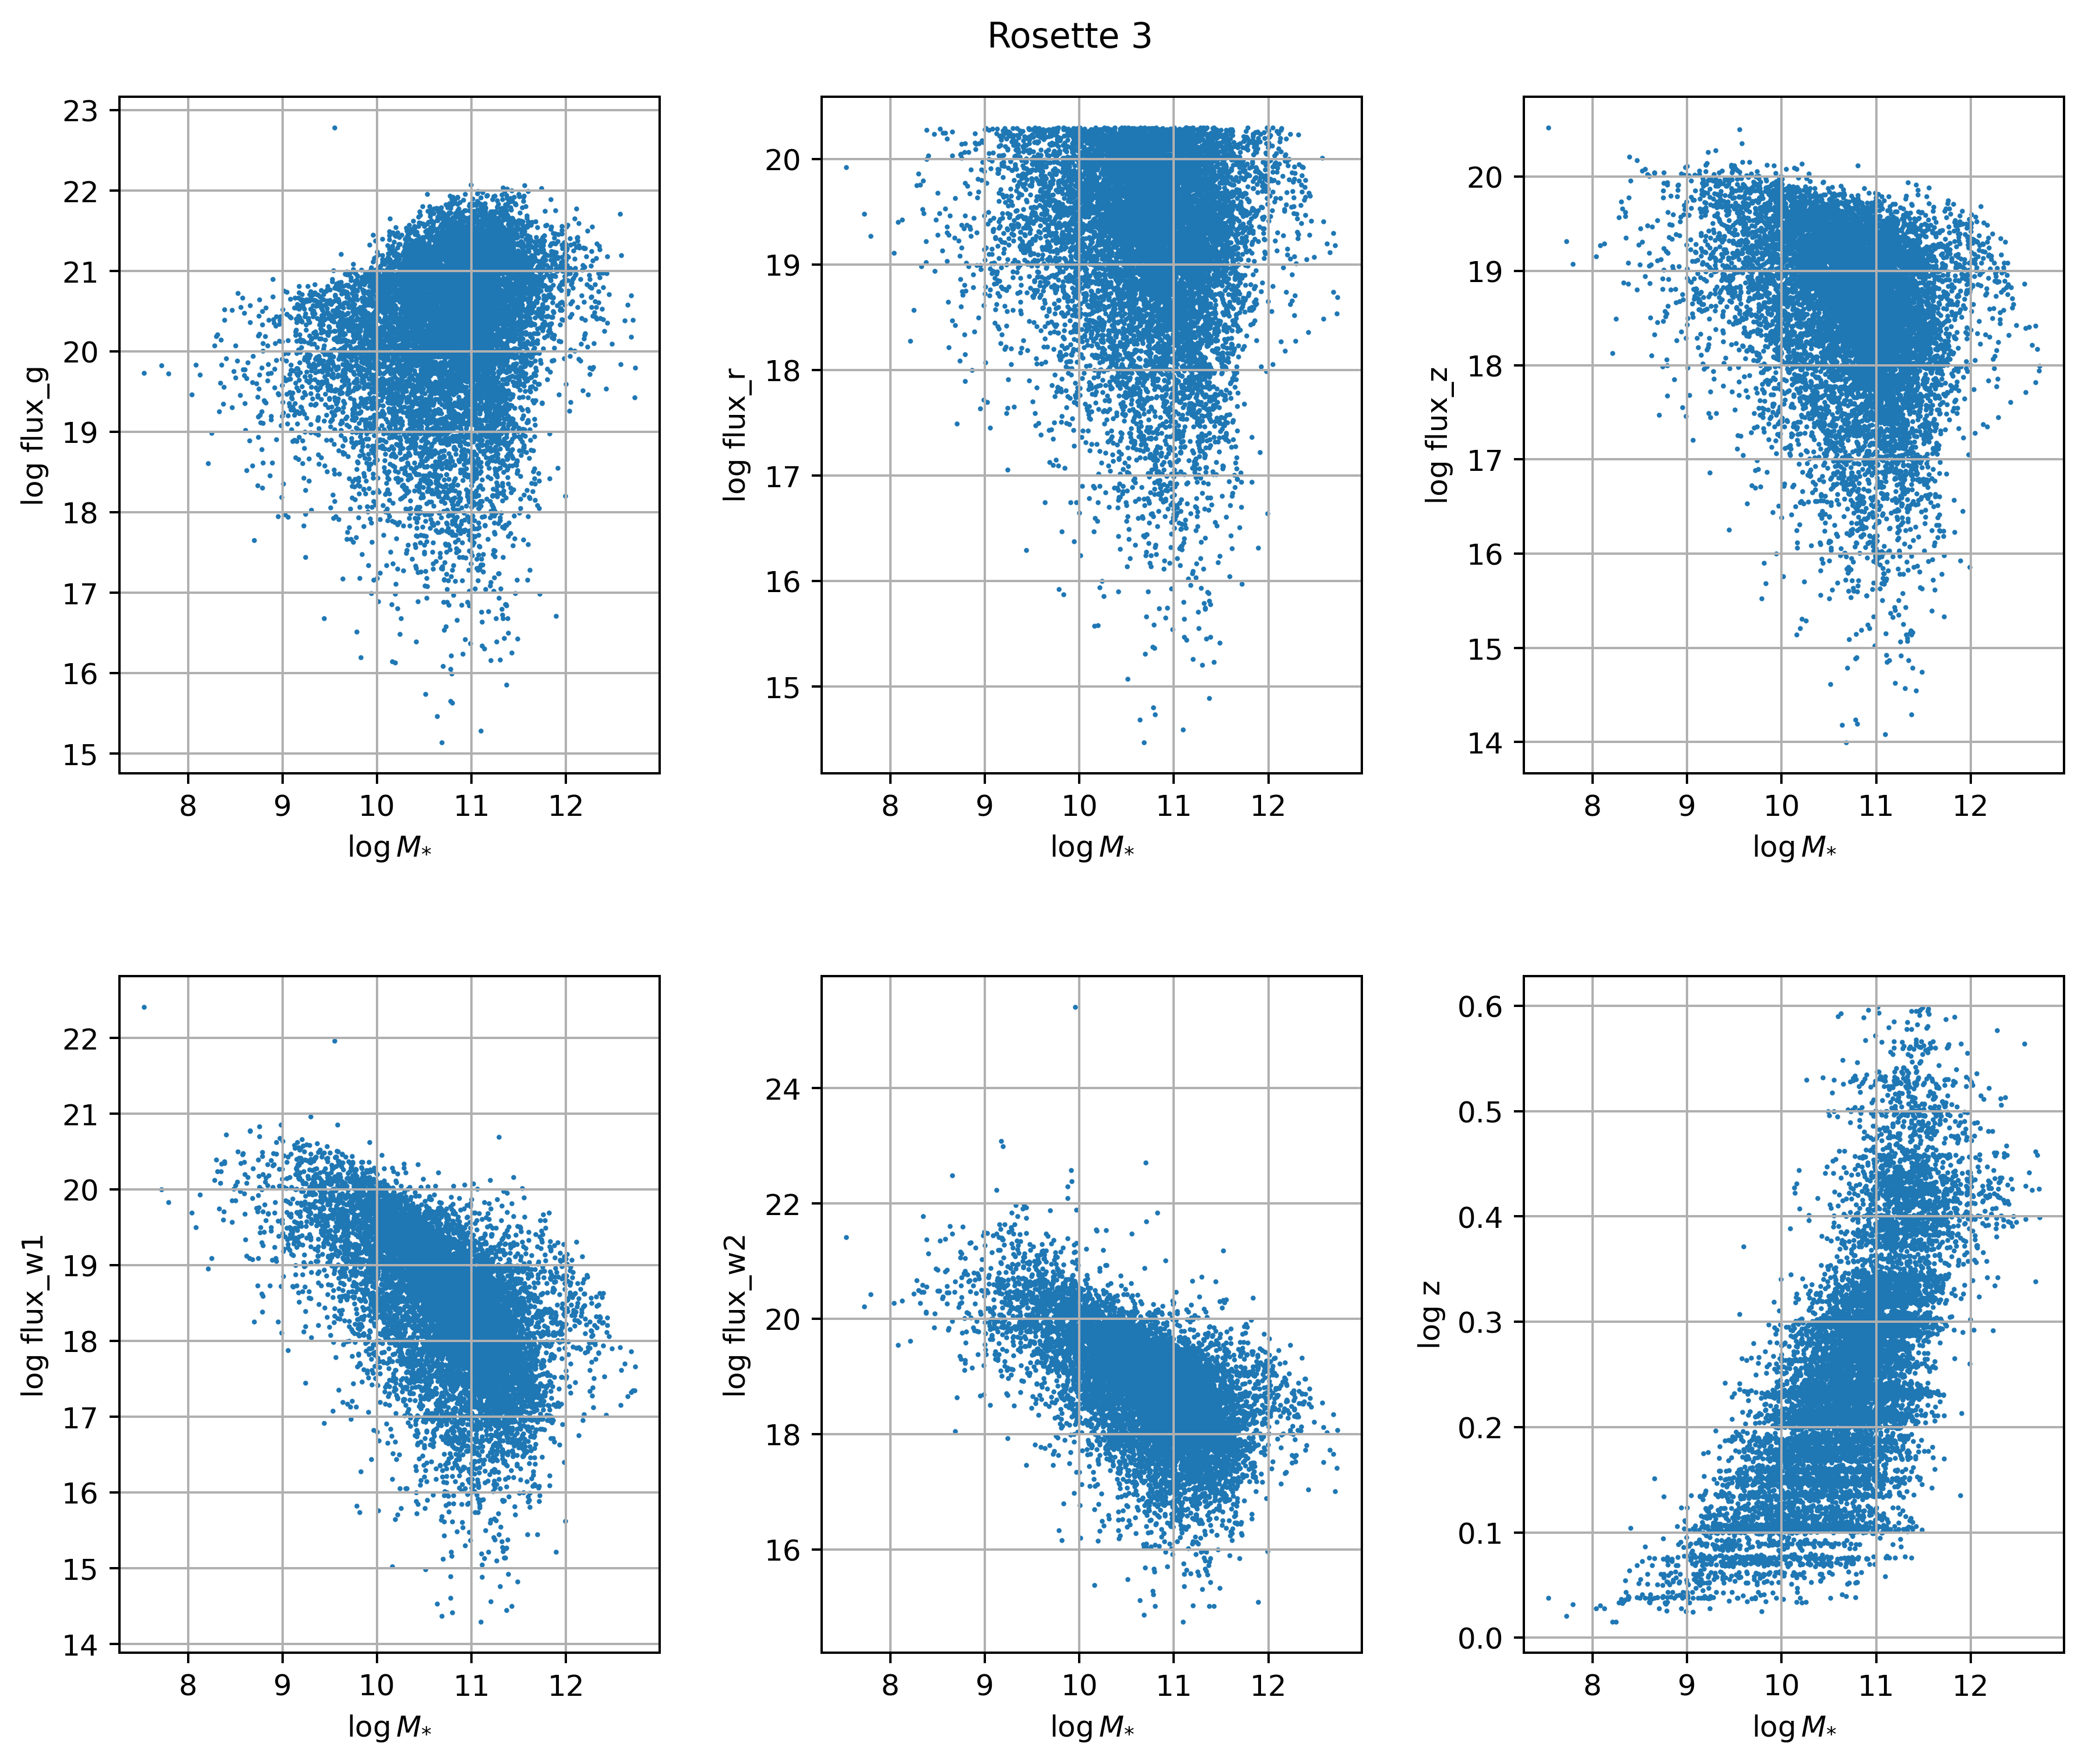

In [8]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
nodes, _, _ = graph_r(3)

m = [n[1] for n in nodes]
flux = np.array([n[2:] for n in nodes])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'Rosette 3', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(2):
    for j in range(3):
        axes[i, j].scatter(m, flux[:,i*3+j], s=0.5)
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {props[i*3+j]}')
        axes[i, j].grid()

## Models

### Linear Model

#### Including **one** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [9]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
x_pred, y_pred, mses = [], [], []

for p in range(len(props)):
    X, y = [], []
    model = LinearRegression()

    for r in rosettes[:1]: #* Rosette 3
        nodes, _, _ = graph_r(r)
        y.extend(np.array([n[p+2] for n in nodes])) #input flux-z
        X.extend(np.array([n[1] for n in nodes]).reshape(-1, 1)) #mass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
    model.fit(X_train, y_train)

    x_pred.append([t[0] for t in X_test])
    y_pred.append((y_test,model.predict(X_test)))
    mses.append((model.score(X_test, y_test),mean_squared_error(y_test, model.predict(X_test))))
    print(f'R^2, {props[p]}: {mses[-1][0]}, mse: {mses[-1][1]}')

R^2, flux_g: 0.03044943342449158, mse: 0.8854501578089752
R^2, flux_r: 0.01052191787870882, mse: 0.7044734798178878
R^2, flux_z: 0.07607064014167875, mse: 0.6757343430651922
R^2, flux_w1: 0.32263148541794007, mse: 0.5458616416587874
R^2, flux_w2: 0.3495588054554206, mse: 0.5486365457354523
R^2, z: 0.5048512357831567, mse: 0.0058458452407168255


Predictions in the same rosette

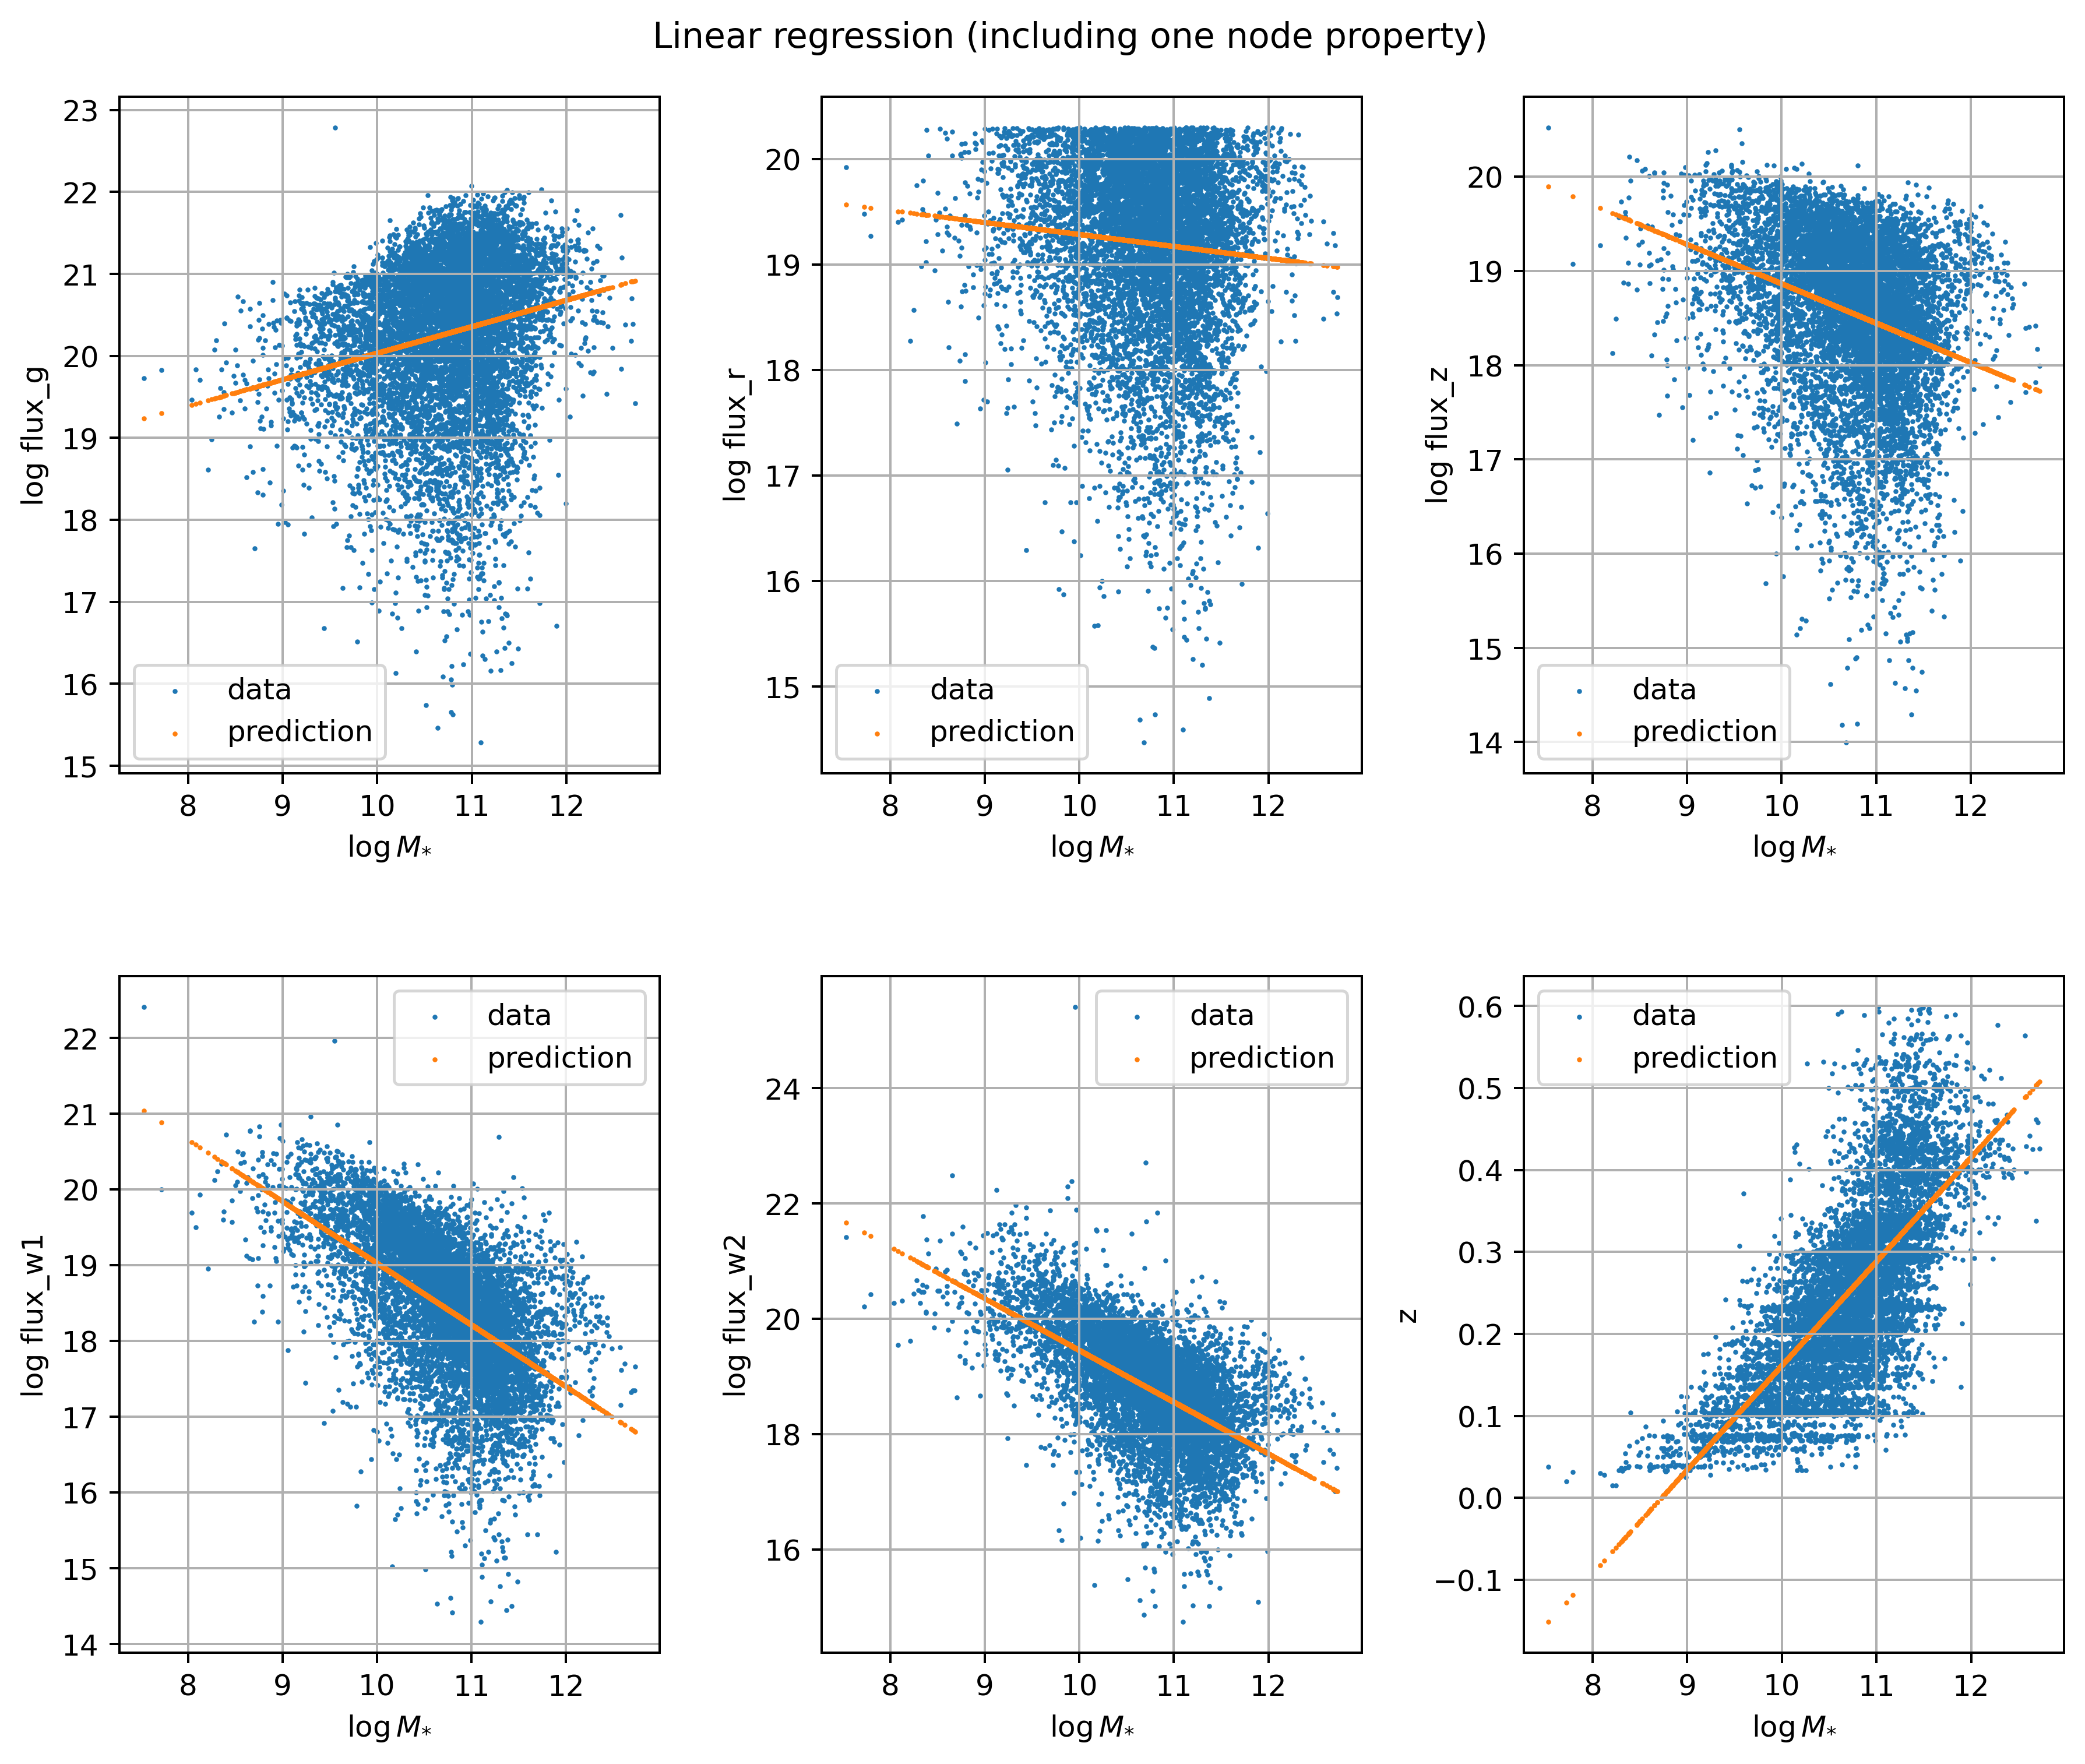

In [10]:
props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z']
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

x_pred, y_pred = np.array(x_pred), np.array(y_pred)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][0], s=0.5, label='data')
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][1], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'{props[i*ncols+j]}')
        axes[i, j].grid()

plt.suptitle('Linear regression (including one node property)', y=1.02)
plt.show()

Predictions in a different rosette

In [12]:
x_pred, y_pred = [], []
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for p in range(len(props)):
    X, y, ms = [], [], []

    for r in rosettes[1:2]: #* Rosette 6
        nodes, _, _ = graph_r(r)
        y.extend(np.array([n[p+2] for n in nodes])) #input flux-z
        X.extend(np.array([n[1] for n in nodes]).reshape(-1, 1)) #mass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9) #*training

    x_pred.append([t[0] for t in X_test])
    y_pred.append((y_test,model.predict(X_test)))

    ms.append((model.score(X_test, y_test),mean_squared_error(y_test, model.predict(X_test))))
    print(f'R^2, {props[p]}: {ms[-1][0]}, mse: {ms[-1][1]}')

R^2, flux_g: -412.29234191300725, mse: 401.9747932132542
R^2, flux_r: -476.4465971310696, mse: 360.8447165207386
R^2, flux_z: -434.12372006811086, mse: 337.1063913722558
R^2, flux_w1: -394.42894409947485, mse: 332.52469350770656
R^2, flux_w2: -385.74104759946664, mse: 345.66312781895385
R^2, z: 0.5319035868231048, mse: 0.0061311060553085


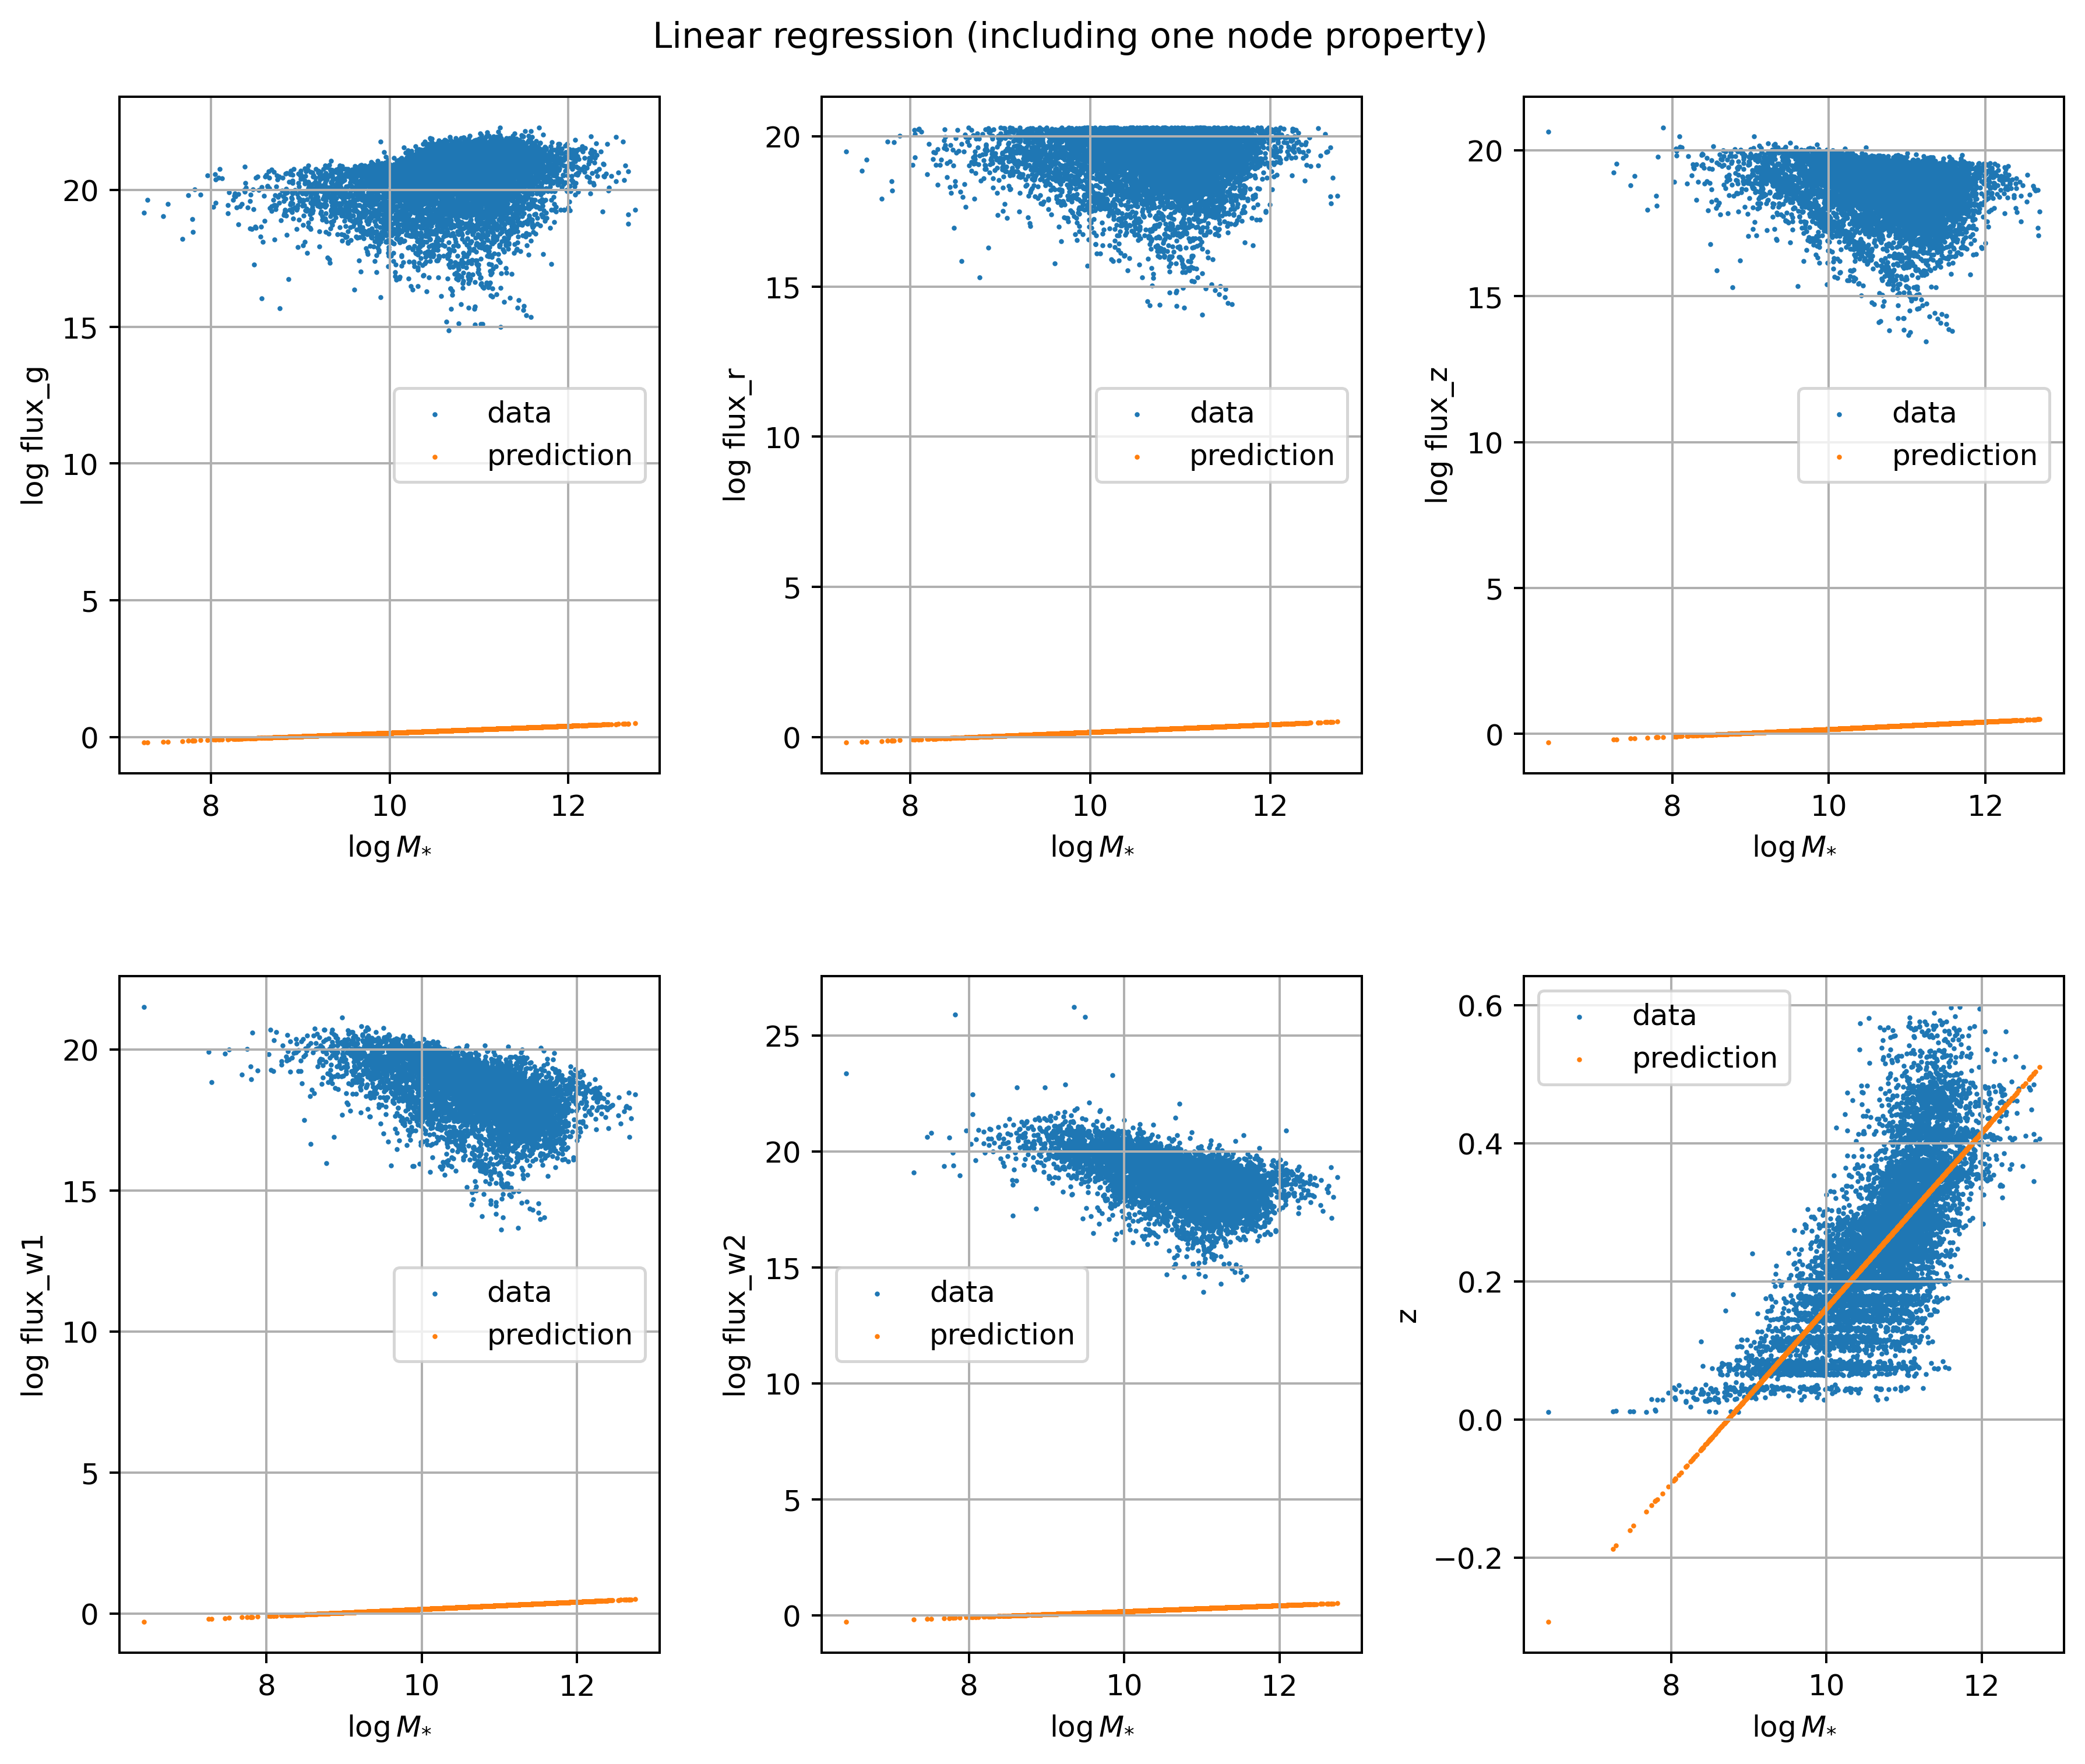

In [14]:
props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z']
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

x_pred, y_pred = np.array(x_pred), np.array(y_pred)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][0], s=0.5, label='data')
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][1], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'{props[i*ncols+j]}')
        axes[i, j].grid()

plt.suptitle('Linear regression (including one node property)', y=1.02)
plt.show()

#### Including **all** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [48]:
model = LinearRegression()

X, y = [], []
for r in rosettes[:1]: #Rosette 3
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
model.fit(X_train, y_train)
print(f'R^2: {model.score(X_test, y_test)}')

R^2: 0.8564431386835739


In [50]:
m = model.coef_
b = model.intercept_
print(f'm: {m}\nb: {b}')

m: [-0.32813634  1.63761907 -1.73141604  0.34549476 -0.28619688  4.52091781]
b: 15.949961503036612


Predictions in the same rosette

In [16]:
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_pred)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 1.0
mse: 0.05158488385994874


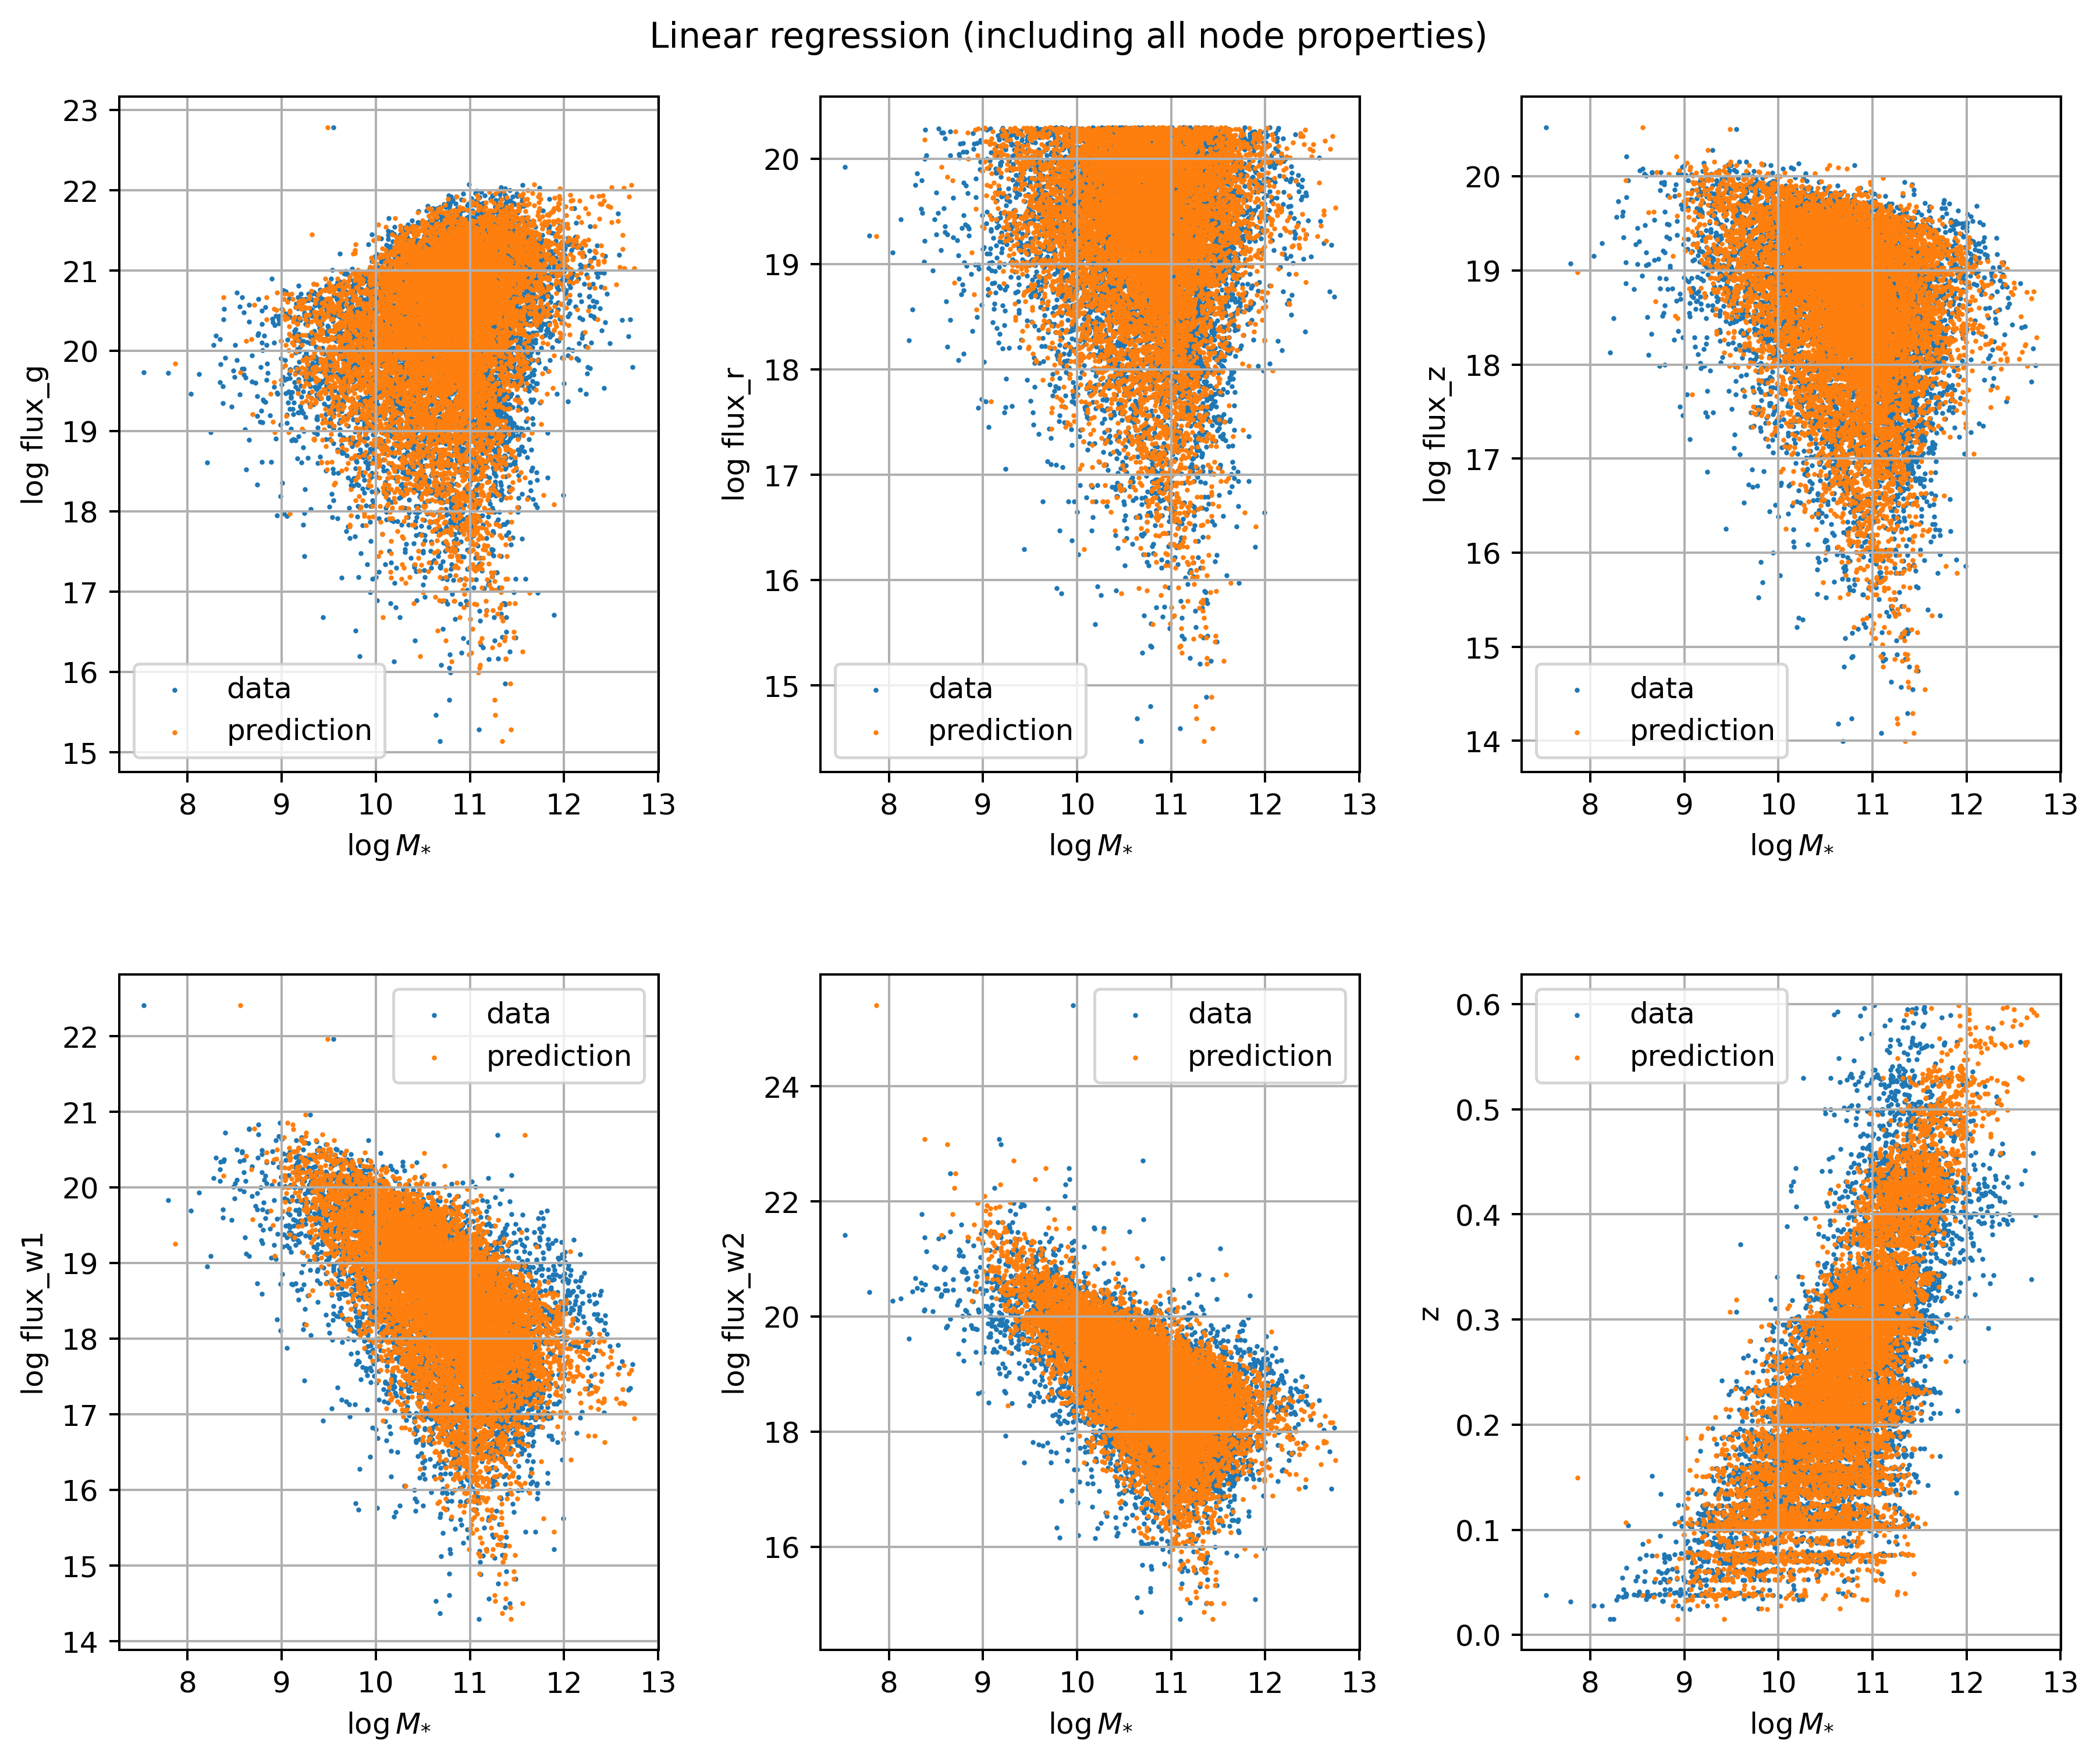

In [18]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

for i in range(nrows):
    for j in range(ncols):
        prop_index = i * ncols + j
        prop_name = props[prop_index]
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_ylabel(f'{prop_name}')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].grid()

plt.suptitle('Linear regression (including all node properties)', y=1.02)
plt.show()

Predictions in a different rosette

In [19]:
X, y = [], []
for r in rosettes[2:3]: #rosette 7
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_test)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 0.8504587642569595
mse: 0.06377041499302755


In [20]:
X, y = [], []
for r in rosettes[1:2]: #rosette 6
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_test)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 0.8612175043329346
mse: 0.0596230033660523


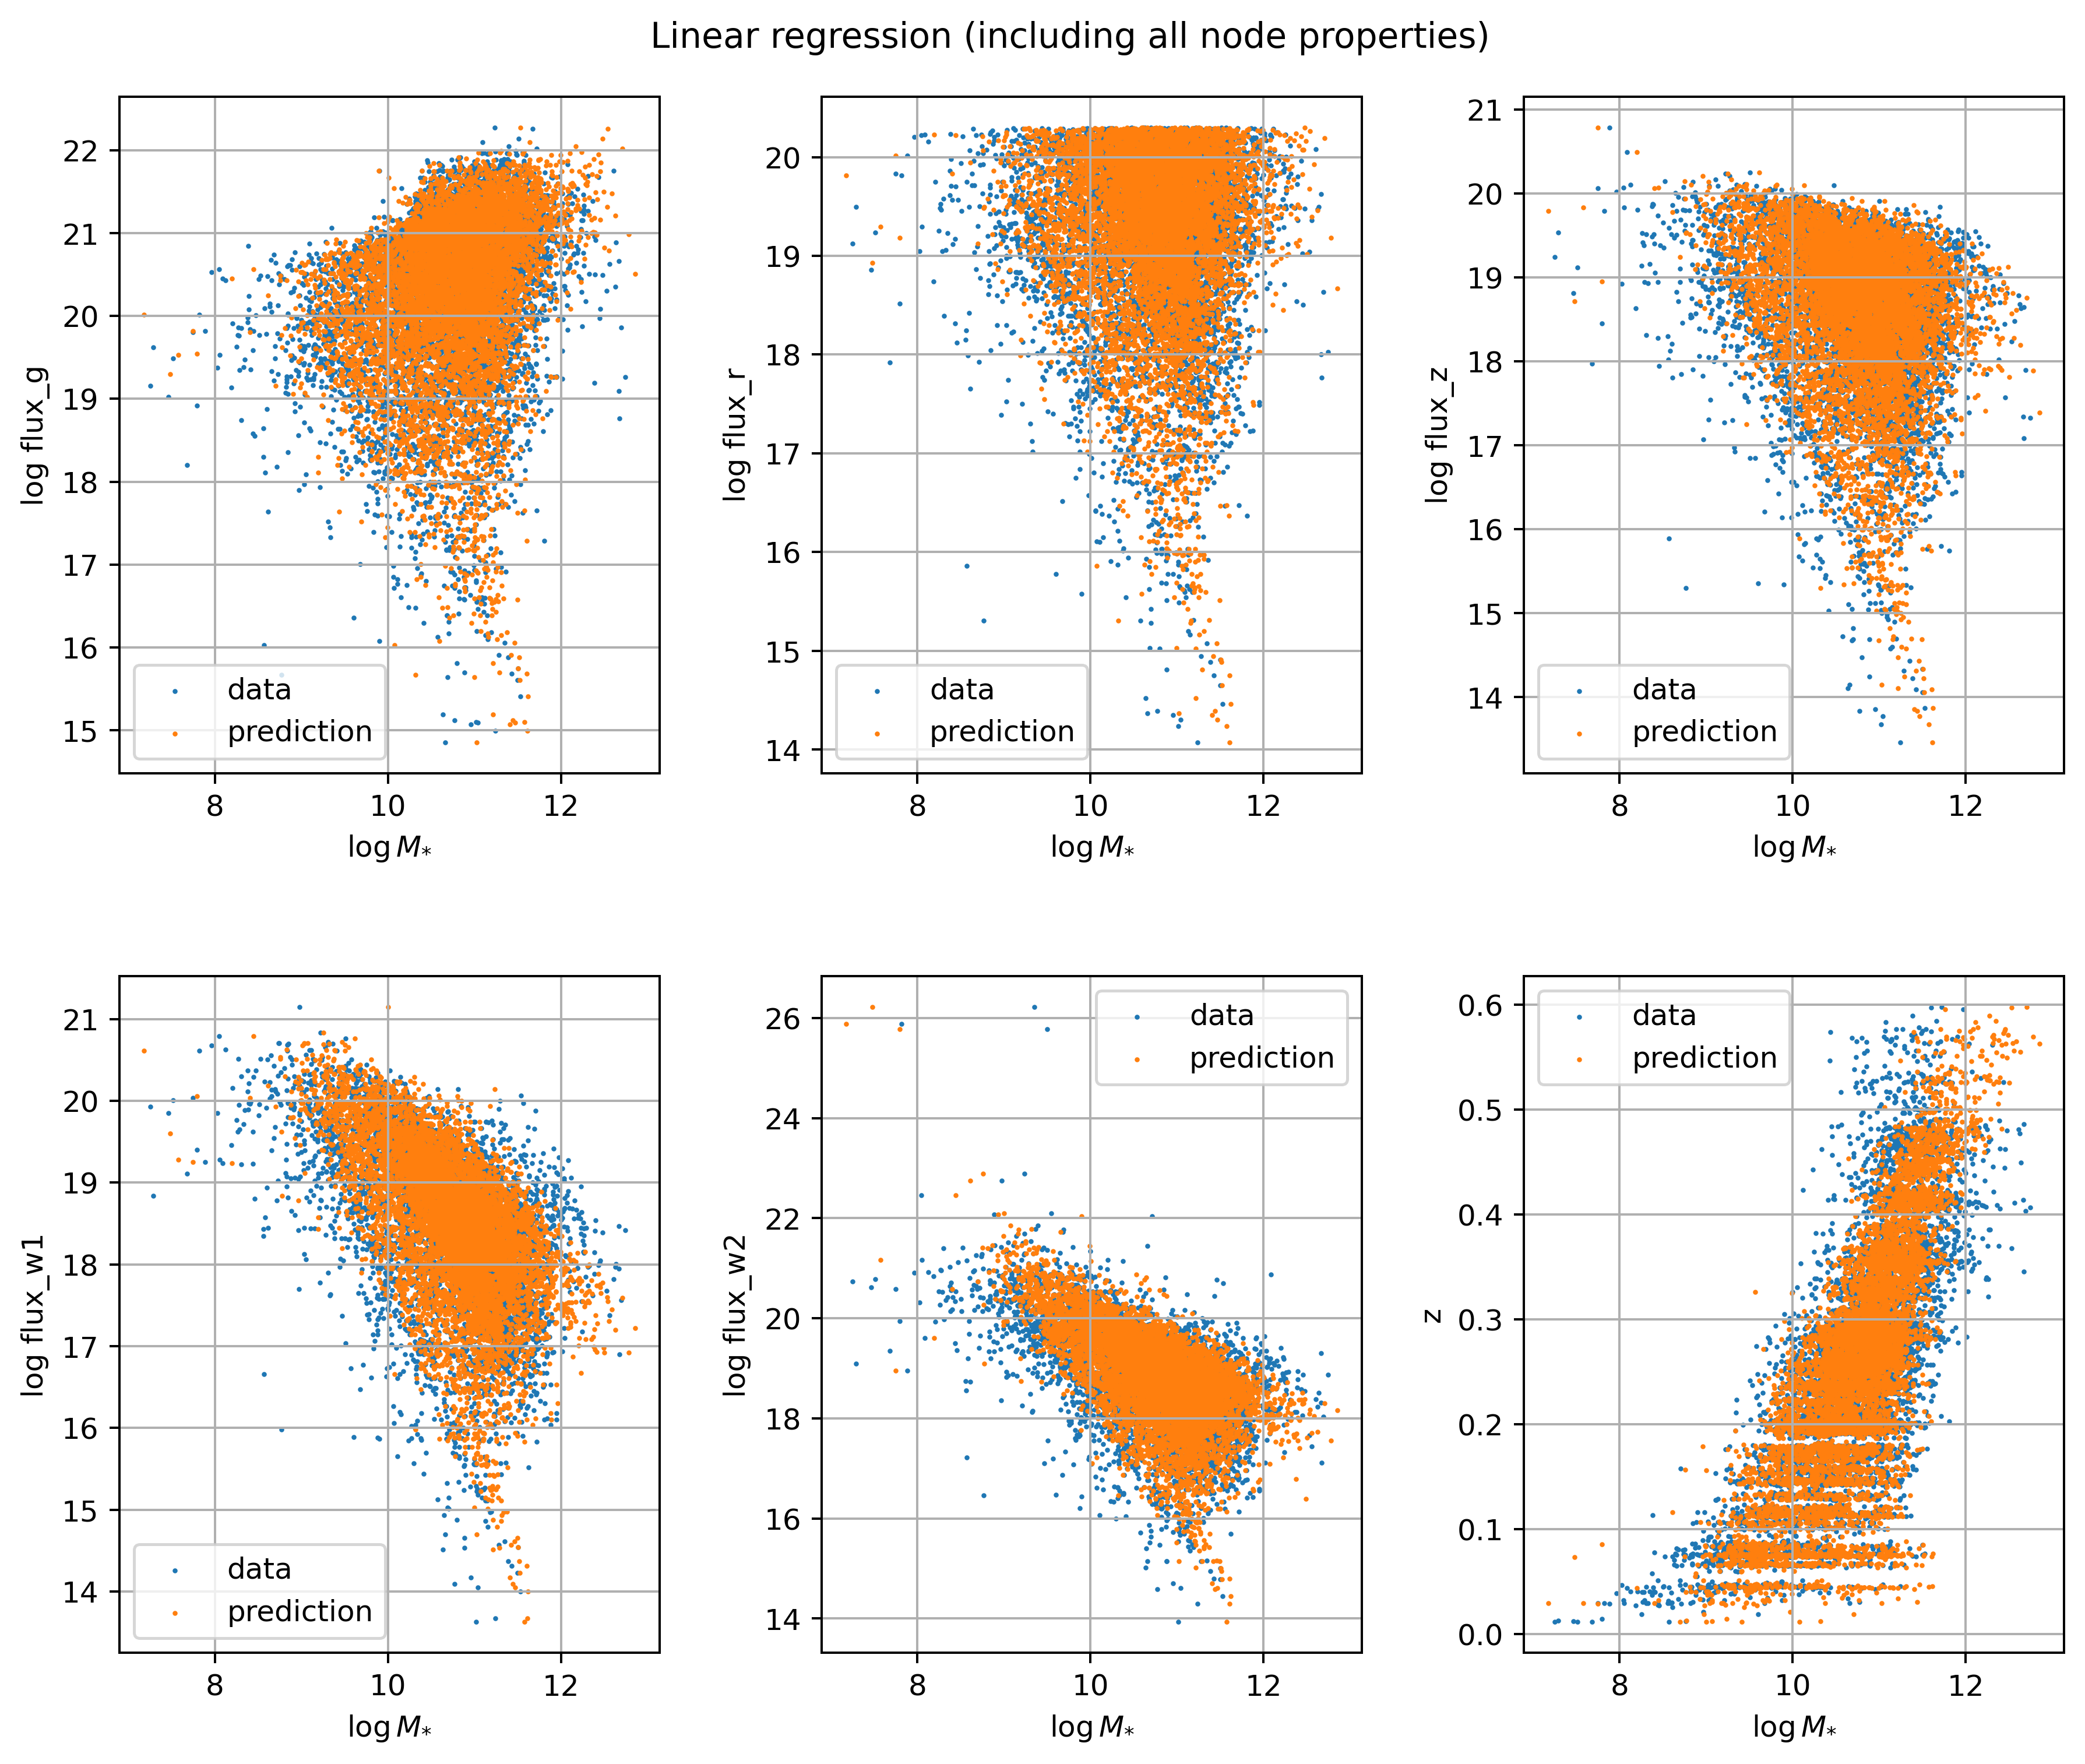

In [22]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

for i in range(nrows):
    for j in range(ncols):
        prop_index = i * ncols + j
        prop_name = props[prop_index]
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')  # Datos reales
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')  # Predicciones
        axes[i, j].legend()
        axes[i, j].set_ylabel(f'{prop_name}')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].grid()

plt.suptitle('Linear regression (including all node properties)', y=1.02)
plt.show()

### Random Forest

In [37]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'mse: {mse}')

mse: 0.035719688968561494


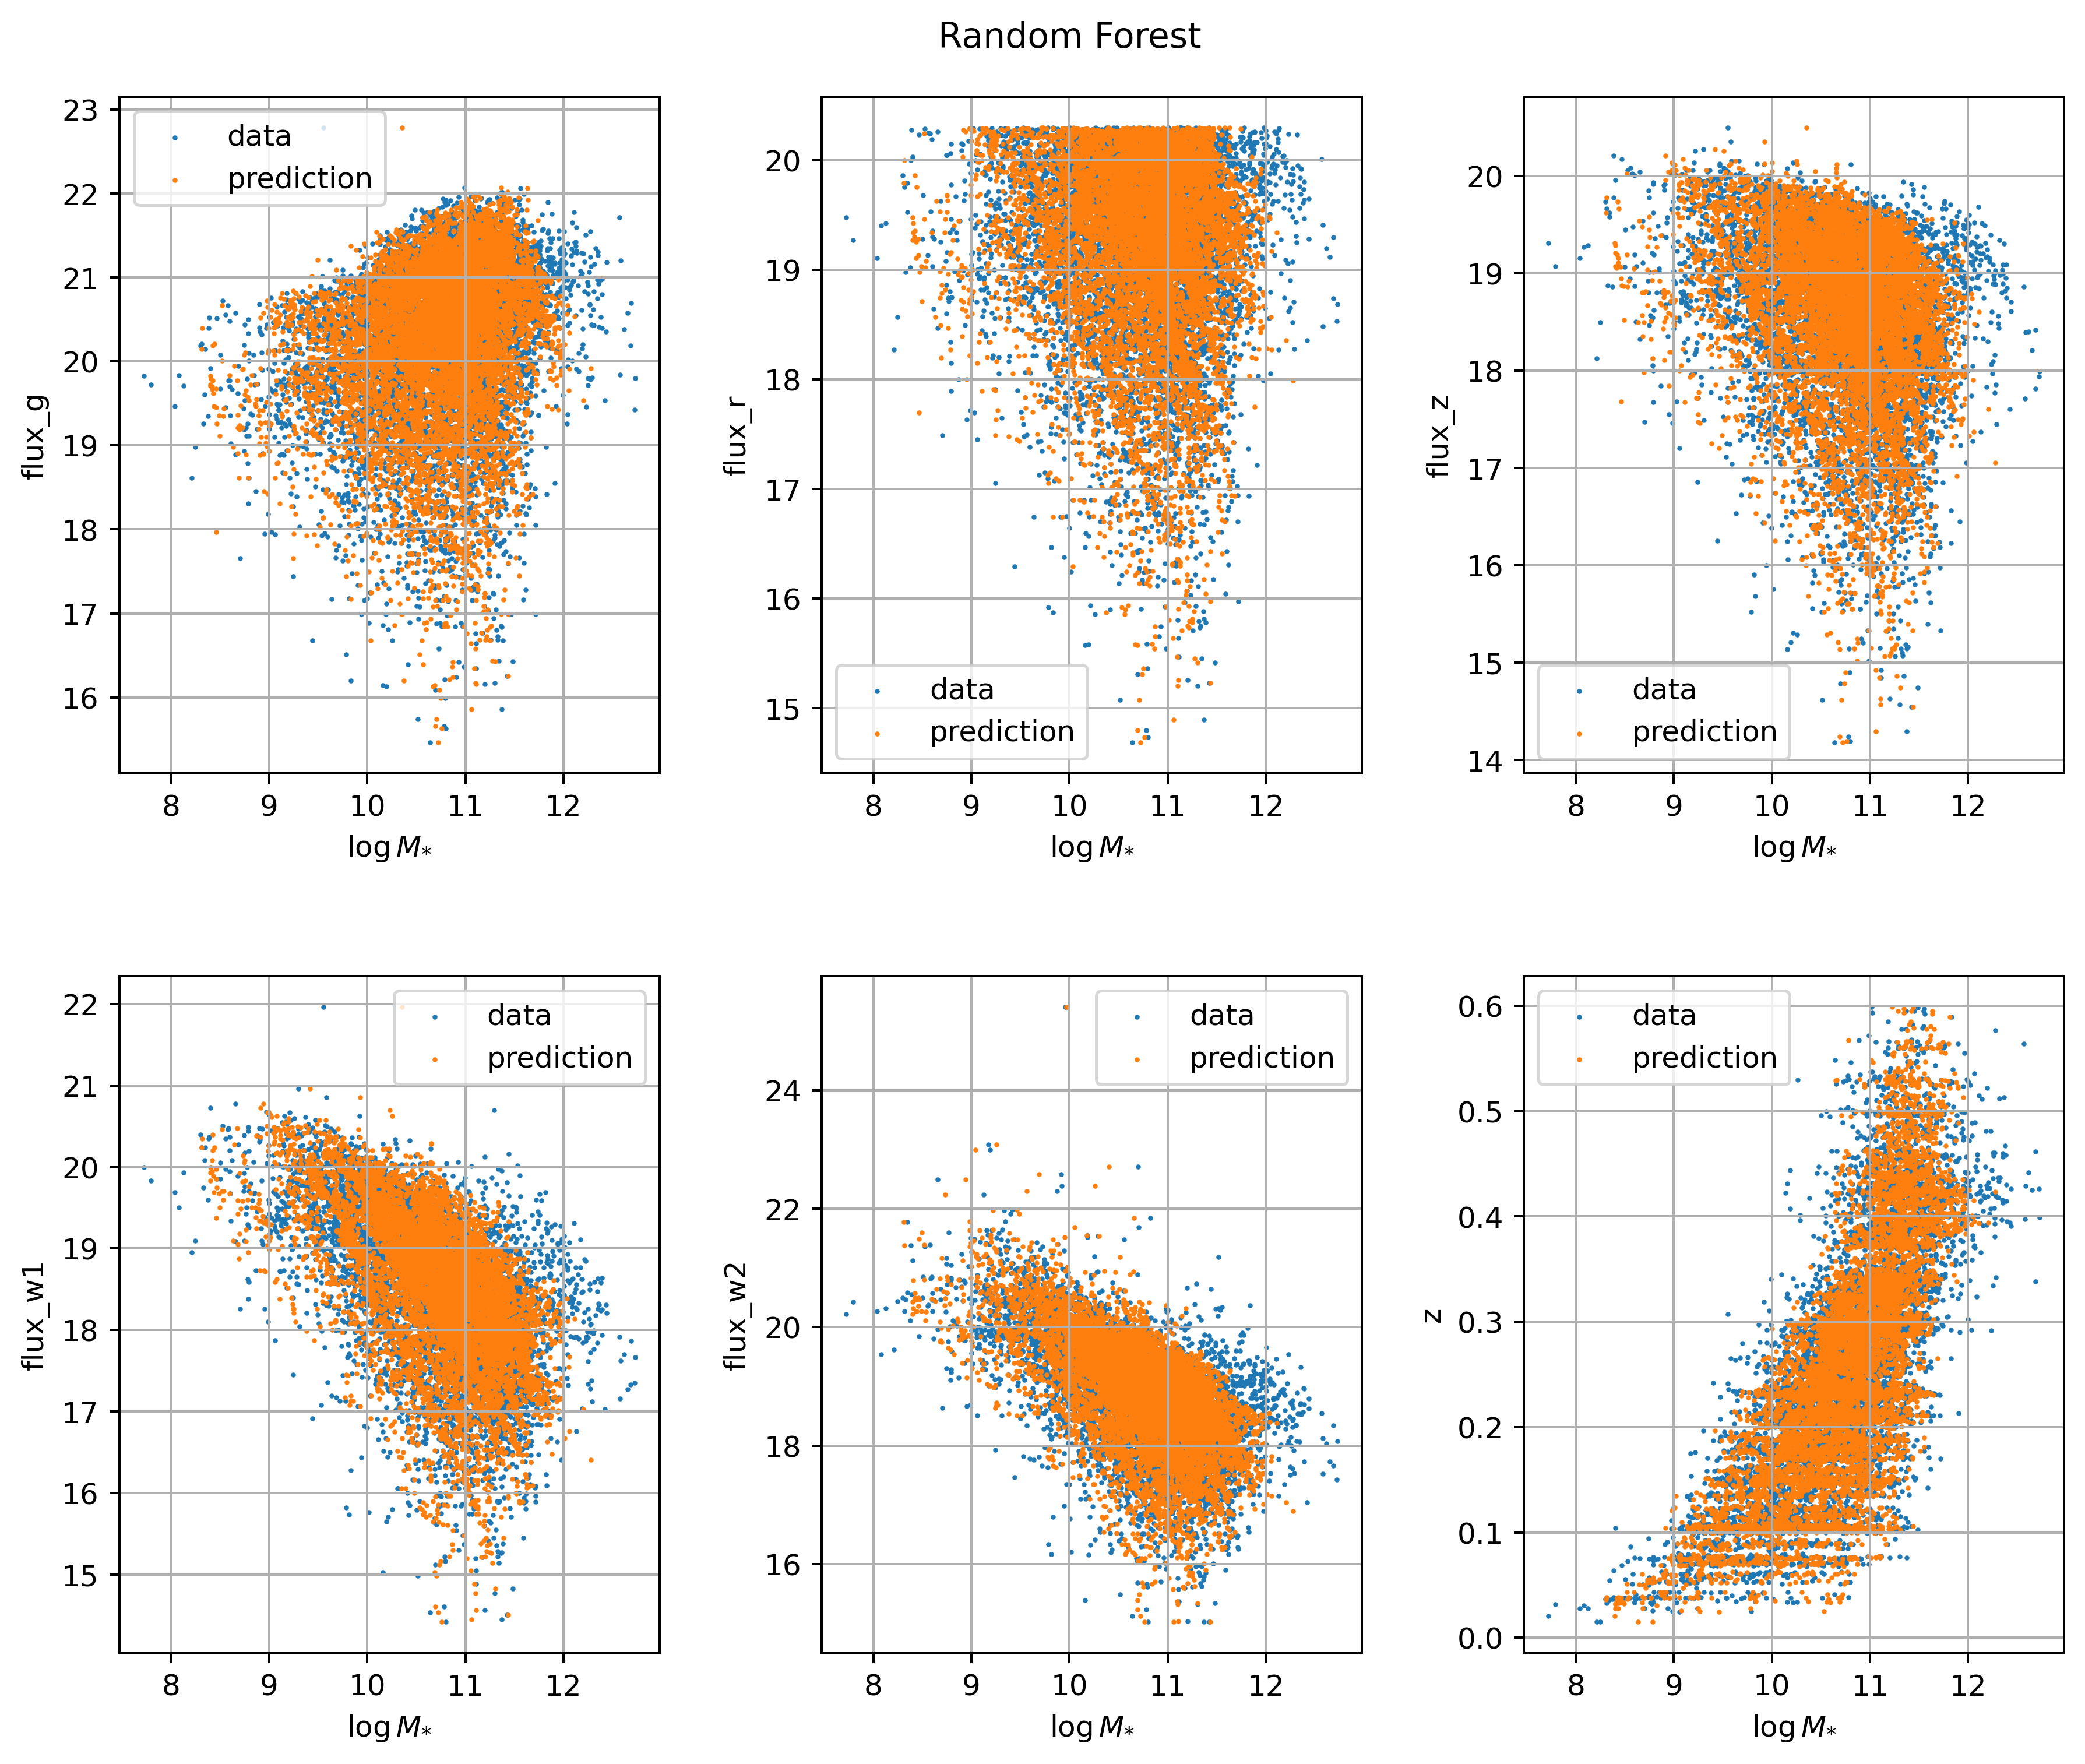

In [38]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle('Random Forest', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for i in range(2):
    for j in range(3):
        prop_index = i * 3 + j
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'{labels[prop_index]}')
        axes[i, j].grid()

plt.show()

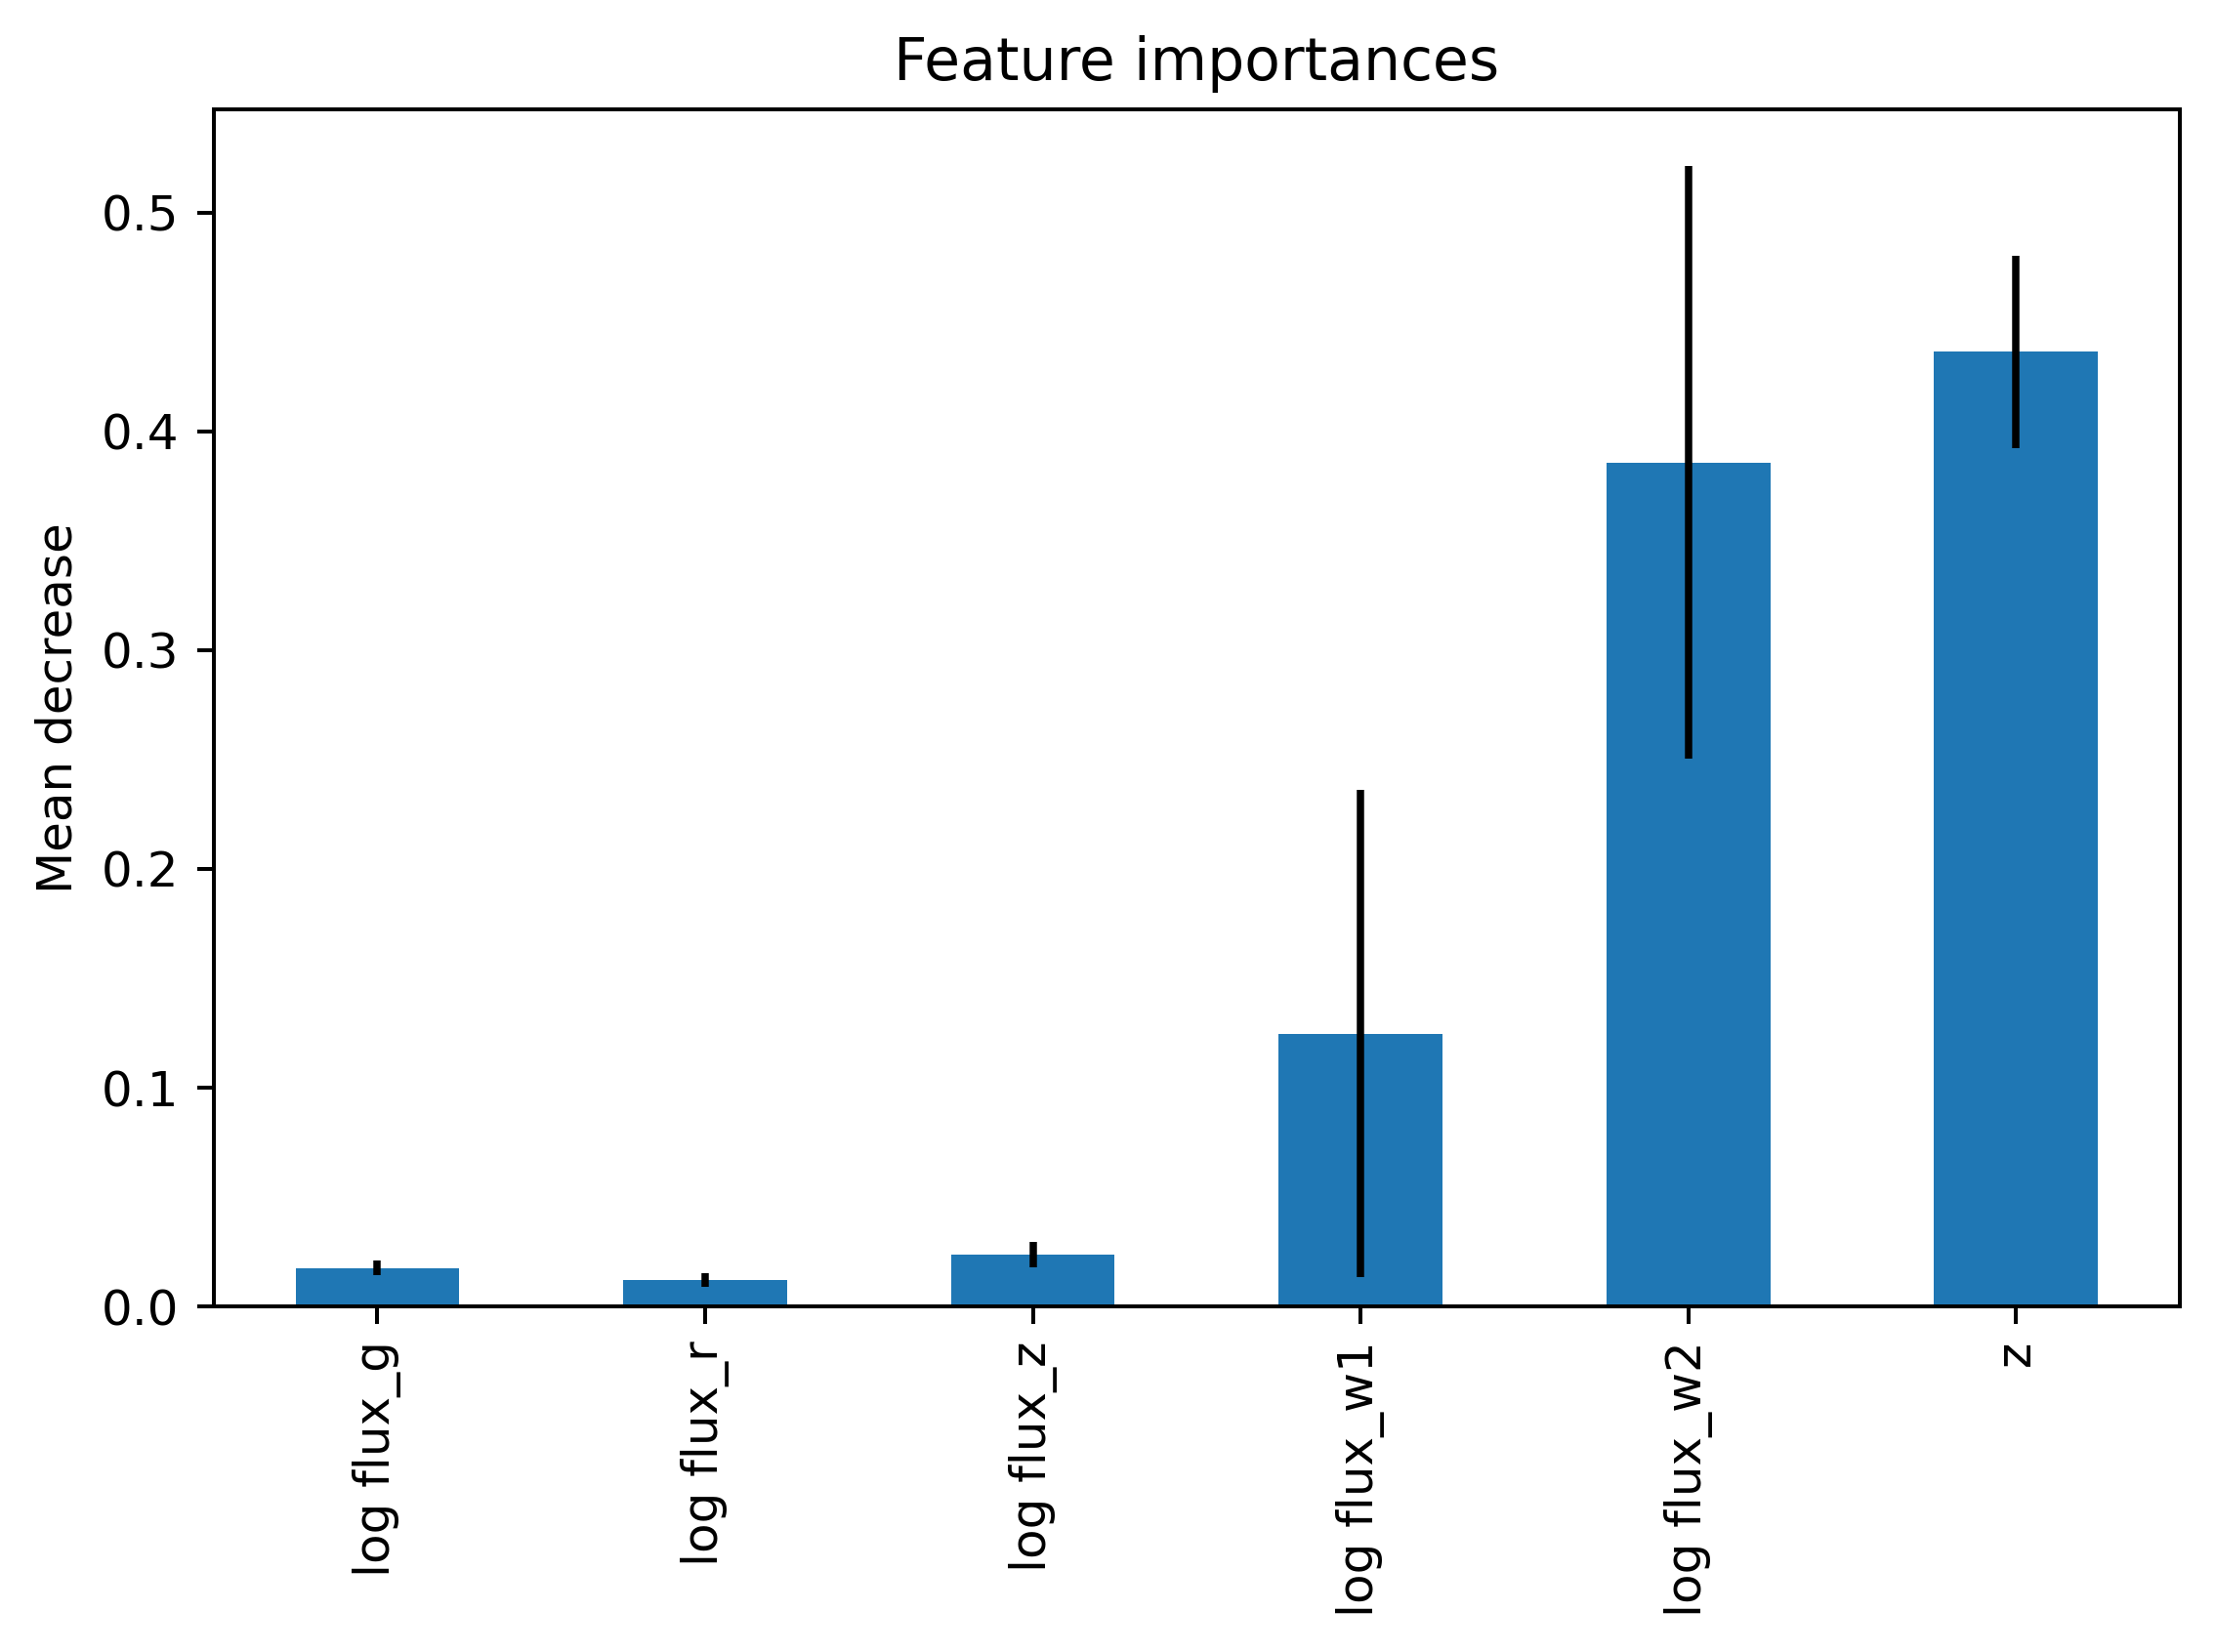

In [39]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z']
feature_names = [f"{i}" for i in props]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Adding a random column

In [40]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor_rdm = RandomForestRegressor(n_estimators=100, random_state=0)

random_column = np.random.rand(len(y_train)) #random column
X_train_extended = np.column_stack((X_train, random_column))
regressor_rdm.fit(X_train_extended, y_train)

X_test_extended = np.column_stack((X_test, np.random.rand(len(y_test))))
y_pred_extended = regressor_rdm.predict(X_test_extended)

mse = mean_squared_error(y_test, y_pred_extended)
print(f'mse: {mse}')

mse: 0.03594289386328839


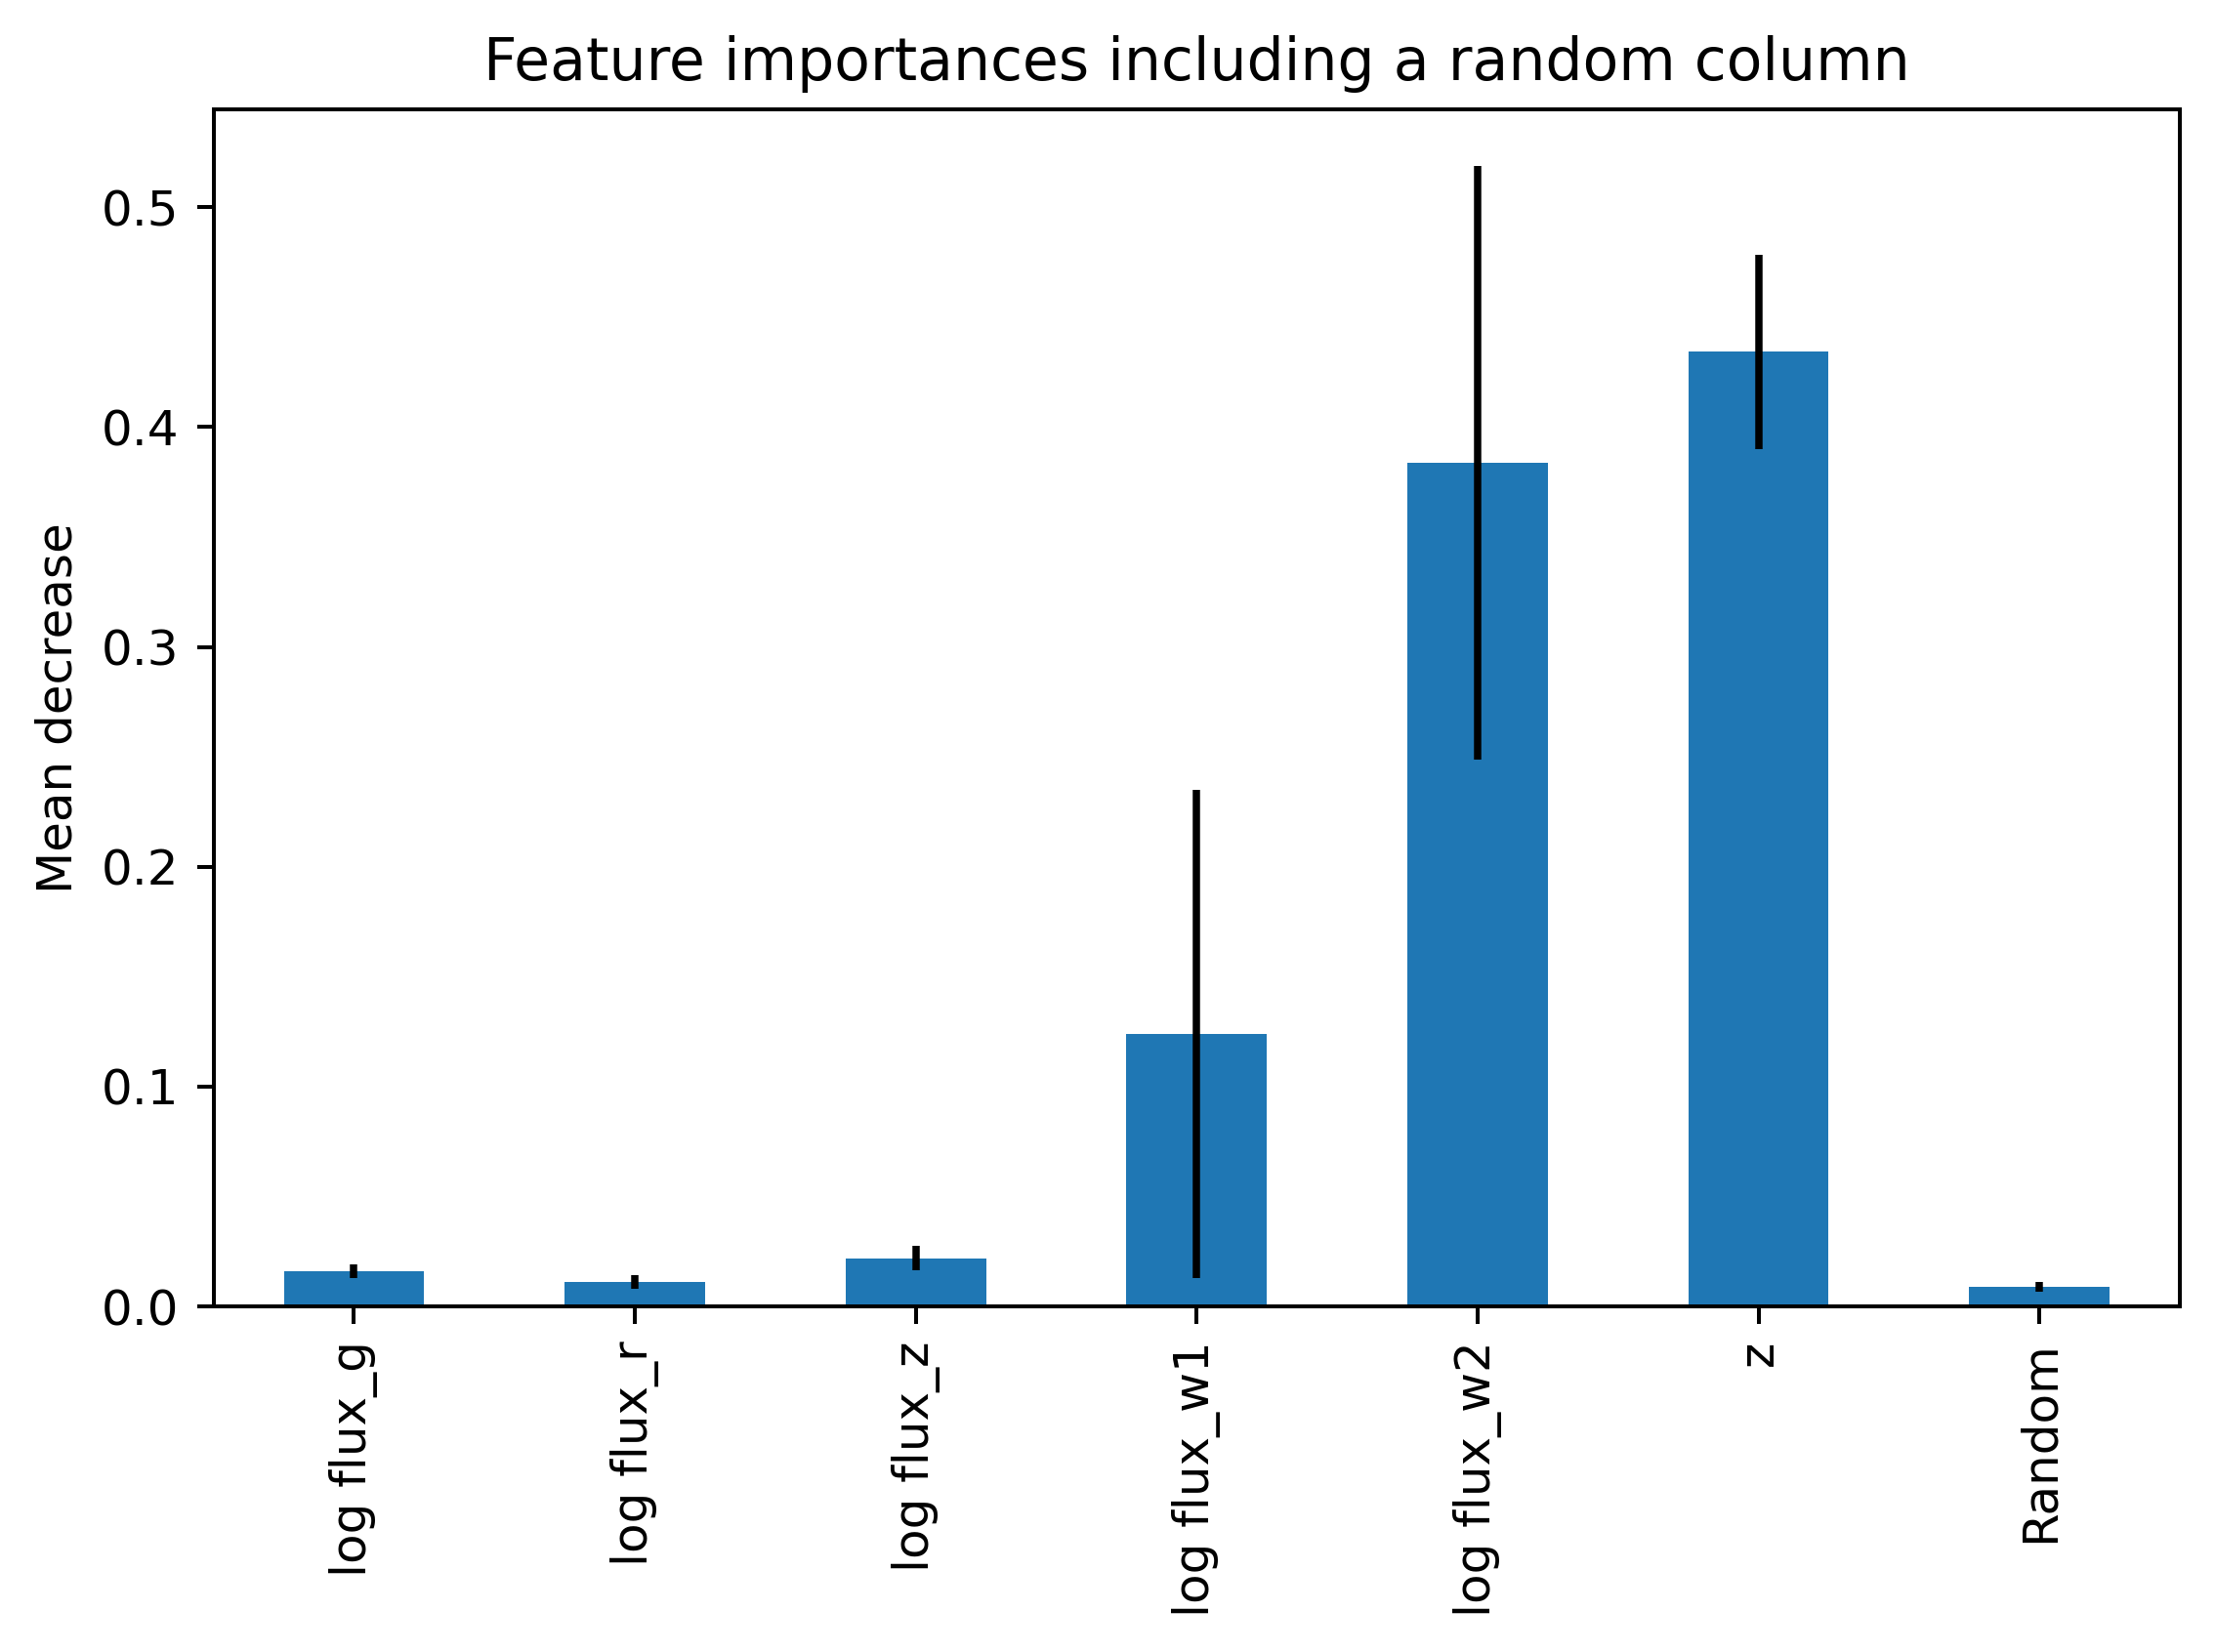

In [41]:
importances = regressor_rdm.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rdm.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z', 'Random']
feature_names = [f"{i}" for i in props[:-1]]
feature_names.append(props[-1])
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances including a random column")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Predictions in a different rosette

In [42]:
nodes, _, _ = graph_r(rosettes[2]) #Rosette 7
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'mse: {mse}')

mse: 0.04477911015755644


In [43]:
nodes, _, _ = graph_r(rosettes[1]) #Rosette 6
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'mse: {mse}')

mse: 0.04204795241196711


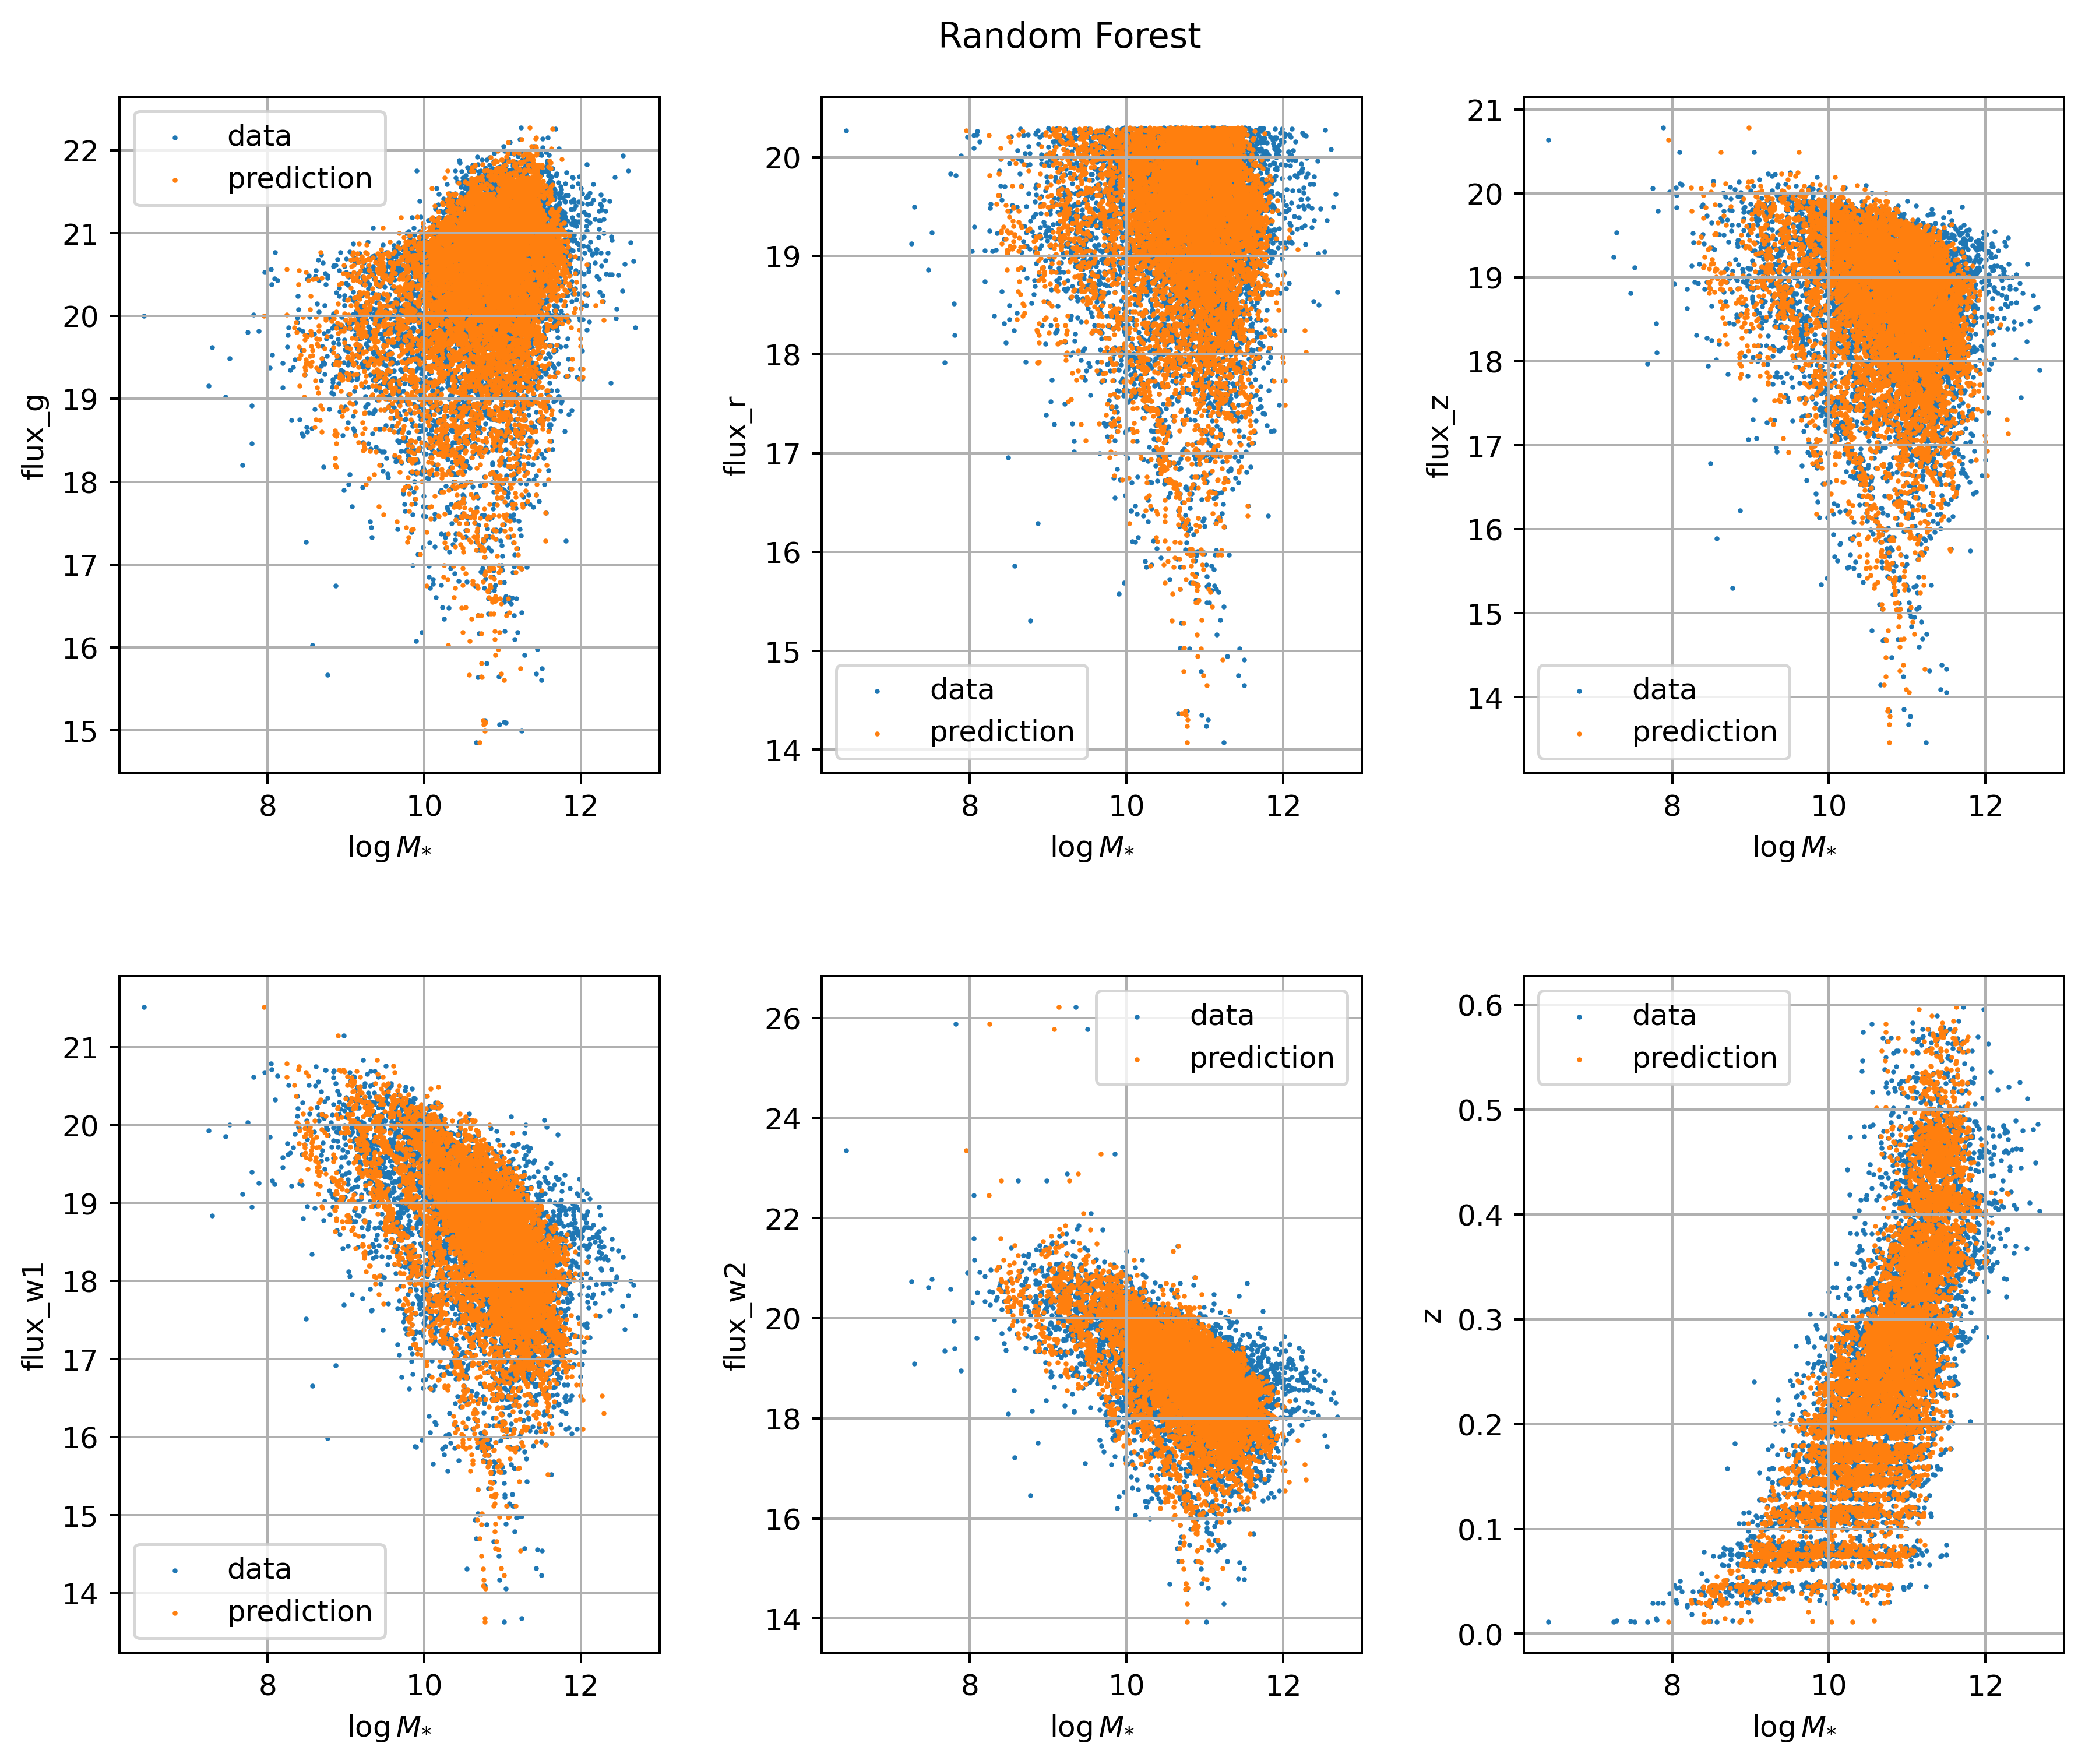

In [44]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle('Random Forest', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for i in range(2):
    for j in range(3):
        prop_index = i * 3 + j
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'{labels[prop_index]}')
        axes[i, j].grid()

plt.show()

### Mean squared error results

<div style="text-align:center; display: flex; justify-content: center;">
  <table>
    <tr>
      <th style="border: none;"></th>
      <th colspan="2">mse</th>
    </tr>
    <tr>
      <th>Data</th>
      <th>Linear</th>
      <th>Random Forest</th>
    </tr>
    <tr>
      <td>Train (Rosette 3)</td>
      <td>0.0515</td>
      <td>0.0357</td>
    </tr>
    <tr>
      <td>Test (Rosette 6)</td>
      <td>0.0420</td>
      <td>0.0596</td>
    </tr>
    <tr>
      <td>Test (Rosette 7)</td>
      <td>0.0637</td>
      <td>0.0447</td>
    </tr>
  </table>
</div>
